In [68]:
from dataset.msc_summary_turns import MSC_Turns
from dataset.msc_summary import MSC_Summaries
from dataset.msc_summary import plot_heatmaps
import json
import pandas as pd
import numpy as np
import itertools
import os
import math
from ast import literal_eval
import matplotlib.pyplot as plt

In [69]:
prepfile = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/preprocessed:trained_base_reweighted_bart:session_4_test.json"
with open(prepfile) as f:
    d = json.loads(f.read())
print(len(d))

501


## Load dataset, stats and evalresults

In [75]:
# List the available files in the eval_results directory

eval_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/eval_results/"
files = sorted([item.path for item in os.scandir(eval_results_dir) if not item.is_dir()])
files

['/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_120957_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_120957_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121242_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121242_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121619_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121619_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_122031_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_122031_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eva

In [189]:
# Collect results in dicts
stats_list = []
evalresults_dict = {}
config_list = []

# Load list with ALL trial_names
trial_names = list(set([
    '_'.join((f.split('/')[-1].split('_')[:-1]))
    for f in files
]))

#
# IF NECESSARY: USE ONLY SELF SELECTED FILES
#

# Trials for SUMMARY GENERATION
# selection_fn = lambda s: s.find('trained_nll05_bart_20230722_004127') >= 0 # eval run session 4, Flat-Broad beam search
# selection_fn = lambda s: \
#     (s.find('trained_nll05_bart_202308') >= 0) or \
#     (s.find('trained_nll05_bart_20230722') >= 0 and \
#      s.find('trained_nll05_bart_20230722_00') == -1)  # FINAL RUN with 40 eval runs with for sessions 1-4, with 9 different generation configs

# selection_fn = lambda s: s.find('20230714_20') >= 0         # test with 100 samples from session 3
# selection_fn = lambda s: s.find('20230628_12') >= 0         # trials with trained2_base_reweighted_bart --> version2
# selection_fn = lambda s: s.find('20230628_2') >= 0          # trials with trained_base_reweighted_bart --> version1

# Trials for FACT EXTRACTION
selection_fn = lambda s: s.find('trained_nll05_bart_20230723') >= 0 # Final run
# trial_names = [
#     'trained_nll05_bart_20230715_191928', 
#     'trained_nll05_bart_20230716_012913', 
#     'trained_nll05_bart_20230715_213740', 
#     'trained_rw05_bart_20230715_190156', 
#     'trained_rw05_bart_20230715_213435'
# ]


trial_names = sorted([f for f in trial_names if selection_fn(f)])


print(f"SELECTED TRIALS ({len(trial_names)}")
print('\n'.join(trial_names))

for trial_name in trial_names:
    with open(f"{eval_results_dir}{trial_name}_stats.txt") as f:
        data = f.read().replace('\n', '')
        stats = json.loads(data.split('}{')[0] + '}')
        stats["trial_name"] = trial_name
        stats["date"] = '_'.join(trial_name.split('_')[-2:])
        config = json.loads('{' + data.split('}{')[1])
        config["trial_name"] = trial_name
        stats_list.append(stats)
        config_list.append(config)

    with open(f"{eval_results_dir}{trial_name}_evalresults.txt") as f:
        data = f.read().replace('\n', '')
        evalresults = json.loads(data.split('}{')[0] + '}')
        evalresults = {literal_eval(k): v for k, v in evalresults.items()}
        for k in evalresults.keys():
            evalresults[k]['trial_name'] = trial_name
        evalresults_dict[trial_name] = evalresults
    
# stats_dict[trial_names[0]]
print(len(stats_list), len(evalresults_dict), len(config_list))

SELECTED TRIALS (1
trained_nll05_bart_20230723_163659
1 1 1


In [190]:
# Convert list with stats and configs to dataframe

all_stats_df = pd.DataFrame.from_dict(stats_list)
all_stats_df = all_stats_df.set_index("trial_name")
all_config_df = pd.DataFrame(config_list)
all_config_df = all_config_df.set_index("trial_name")

In [191]:
# Combine stats with config

all_stats_df = all_stats_df.join(all_config_df, validate="1:1")
all_stats_df

,test_loss,test_classification_loss,test_lm_loss,test_acc,test_perplexity,test_token_prediction_acc,eval_acc,eval_f1,eval_precision,eval_recall,...,test_samples,java_home,terpdir,tmpdir,nli_model,speaker_prefixes,nofact_token,add_tokens,len_context,sessions
trial_name,,,,,,,,,,,,,,,,,,,,,
trained_nll05_bart_20230723_163659,1.078764,0.824534,1.078764,0.8406,4.264922,0.660646,0.843324,0.883759,0.900149,0.867956,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"


In [192]:
all_config_df

,configfile,seed,checkpoint_dir,output_dir,log_interval,loglevel,logdir,load,save,device,...,test_samples,java_home,terpdir,tmpdir,nli_model,speaker_prefixes,nofact_token,add_tokens,len_context,sessions
trial_name,,,,,,,,,,,,,,,,,,,,,
trained_nll05_bart_20230723_163659,None,42,./checkpoints/,./output/,10,VERBOSE,/scratch-local/frankv.3126271/logs/,trained_nll05_bart,,cuda,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"


In [193]:
# Convert eval_results to DataFrame and combine with config

eval_results_df = pd.concat([
    pd.DataFrame.from_records(list(evalresults_dict[trial_name].values()))
    for trial_name in evalresults_dict.keys()
])
eval_results_df = eval_results_df.join(all_config_df, on='trial_name')
eval_results_df.head()

,convai_id,pred_fact,target_fact,nli_pred,nli_target,nli_pred_to_target,nli_target_to_pred,pred_persona,target_persona,numwords_factor,...,test_samples,java_home,terpdir,tmpdir,nli_model,speaker_prefixes,nofact_token,add_tokens,len_context,sessions
0,test_0,1,1,0.996926,0.994330,0.384658,0.994105,I don't own a car. I live in a small town. I e...,I live semi-close towkr. I don't own a car. I ...,0.800000,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
1,test_0,1,1,0.951207,0.984040,0.011001,0.997741,I go to the gym to work out.,I enjoy exercising at the gym.,1.333333,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
2,test_0,1,1,0.990445,0.979994,0.998073,0.997944,I am a computer programmer.,I'm a computer programmer.,1.250000,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
3,test_0,1,1,0.894218,0.972481,0.998901,0.998873,I work in marketing.,I have a marketing job.,0.800000,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
4,test_0,1,1,0.909492,0.977780,0.001790,0.491099,I love meat.,I like grilling steak.,0.750000,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"


## Analysis of persona extraction

### Collect evalresults in Dataframe

In [194]:
# Load the MSC_Turns dataset

basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_personasummary/"
sessions = [1, 2, 3, 4]
subset = 'test'
msc_turns = MSC_Turns(basedir=basedir, sessions=sessions, subset=subset)

In [195]:
# PICK ONE OF THE LOADED TRIALS FOR ANALYSIS OF RESULTS

# evalresults = evalresults_dict["trained_nll05_bart_20230715_213740"]
evalresults = evalresults_dict["trained_nll05_bart_20230723_163659"]  # The 'Final' run

keys = pd.MultiIndex.from_tuples(evalresults.keys())
keys
values = list(evalresults.values())
df = pd.DataFrame.from_records(values, index=keys)
print("Number of samples in this trial: ", len(df))
df.head()

Number of samples in this trial:  22371


convai_id  pred_fact  target_fact  nli_pred  nli_target  \
1 0 0    test_0          1            1  0.996926    0.994330   
    1    test_0          1            1  0.951207    0.984040   
    2    test_0          1            1  0.990445    0.979994   
    3    test_0          1            1  0.894218    0.972481   
    4    test_0          1            1  0.909492    0.977780   

       nli_pred_to_target  nli_target_to_pred  \
1 0 0            0.384658            0.994105   
    1            0.011001            0.997741   
    2            0.998073            0.997944   
    3            0.998901            0.998873   
    4            0.001790            0.491099   

                                            pred_persona  \
1 0 0  I don't own a car. I live in a small town. I e...   
    1                       I go to the gym to work out.   
    2                        I am a computer programmer.   
    3                               I work in marketing.   
    4                                       I love meat.   

                                          target_persona  numwords_factor  \
1 0 0  I live semi-close towkr. I don't own a car. I ...         0.800000   
    1                     I enjoy exercising at the gym.         1.333333   
    2                         I'm a computer programmer.         1.250000   
    3                            I have a marketing job.         0.800000   
    4                             I like grilling steak.         0.750000   

       len_p_split  len_t_split      terp  \
1 0 0          3.0          4.0  0.437776   
    1          1.0          1.0  0.598979   
    2          1.0          1.0  0.363080   
    3          1.0          1.0  0.756672   
    4          1.0          1.0  0.631376   

                                              terpscores    terpf1  \
1 0 0  [[1.0, 0.9077003002166748, 1.0], [0.0, 0.98569...  0.857143   
    1                             [[0.6988091468811035]]  1.000000   
    2                             [[0.4538501501083374]]  1.000000   
    3                             [[0.9080064296722412]]  0.000000   
    4                             [[0.7892205119132996]]  0.000000   

       terpprecision  terprecall                          trial_name  
1 0 0            1.0        0.75  trained_nll05_bart_20230723_163659  
    1            1.0        1.00  trained_nll05_bart_20230723_163659  
    2            1.0        1.00  trained_nll05_bart_20230723_163659  
    3            0.0        0.00  trained_nll05_bart_20230723_163659  
    4            0.0        0.00  trained_nll05_bart_20230723_163659

In [196]:
###
### Add the item measurements to the dataframe
###

m = msc_turns.measurements()['allitem_measurements']
df_m = pd.DataFrame.from_records(m)
df_m.index = pd.MultiIndex.from_arrays(df_m[['session', 'dialog_id', 'turn_id']].values.T)
df_m = df_m.drop(['convai_id'], axis=1)
df = df.join(df_m, how='inner')

# Add length of prediction
def get_length(sentence):
    l = len(sentence.split())
    return l

df['predictionwords'] = df['pred_persona'].apply(lambda x: get_length(x))
df.columns


Index(['convai_id', 'pred_fact', 'target_fact', 'nli_pred', 'nli_target',
       'nli_pred_to_target', 'nli_target_to_pred', 'pred_persona',
       'target_persona', 'numwords_factor', 'len_p_split', 'len_t_split',
       'terp', 'terpscores', 'terpf1', 'terpprecision', 'terprecall',
       'trial_name', 'session', 'dialog_id', 'turn_id', 'inputwords',
       'labelwords', 'predictionwords'],
      dtype='object')

In [197]:
###
### Add the input sentence from dataset to the dataframe
###

df['history'] = [msc_turns[i][0].replace('\n', '<sep>') for i in range(len(msc_turns))]
df

convai_id  pred_fact  target_fact  nli_pred  nli_target  \
1 0   0      test_0          1            1  0.996926    0.994330   
      1      test_0          1            1  0.951207    0.984040   
      2      test_0          1            1  0.990445    0.979994   
      3      test_0          1            1  0.894218    0.972481   
      4      test_0          1            1  0.909492    0.977780   
...             ...        ...          ...       ...         ...   
4 500 6   test_1014          1            1  0.989097    0.993115   
      7   test_1014          0            0       NaN         NaN   
      8   test_1014          0            0       NaN         NaN   
      9   test_1014          1            1  0.951873    0.950607   
      10  test_1014          0            0       NaN         NaN   

          nli_pred_to_target  nli_target_to_pred  \
1 0   0             0.384658            0.994105   
      1             0.011001            0.997741   
      2             0.998073            0.997944   
      3             0.998901            0.998873   
      4             0.001790            0.491099   
...                      ...                 ...   
4 500 6             0.995964            0.576474   
      7                  NaN                 NaN   
      8                  NaN                 NaN   
      9             0.000857            0.990895   
      10                 NaN                 NaN   

                                               pred_persona  \
1 0   0   I don't own a car. I live in a small town. I e...   
      1                        I go to the gym to work out.   
      2                         I am a computer programmer.   
      3                                I work in marketing.   
      4                                        I love meat.   
...                                                     ...   
4 500 6                         I have visited Denver once.   
      7                                                       
      8                                                       
      9                                    I have a family.   
      10                                                      

                                             target_persona  numwords_factor  \
1 0   0   I live semi-close towkr. I don't own a car. I ...         0.800000   
      1                      I enjoy exercising at the gym.         1.333333   
      2                          I'm a computer programmer.         1.250000   
      3                             I have a marketing job.         0.800000   
      4                              I like grilling steak.         0.750000   
...                                                     ...              ...   
4 500 6                              I have visited Denver.         1.250000   
      7                                                                  NaN   
      8                                                                  NaN   
      9              I will be doing a hike with my family.         0.444444   
      10                                                                 NaN   

          ...  terpprecision  terprecall                          trial_name  \
1 0   0   ...            1.0        0.75  trained_nll05_bart_20230723_163659   
      1   ...            1.0        1.00  trained_nll05_bart_20230723_163659   
      2   ...            1.0        1.00  trained_nll05_bart_20230723_163659   
      3   ...            0.0        0.00  trained_nll05_bart_20230723_163659   
      4   ...            0.0        0.00  trained_nll05_bart_20230723_163659   
...       ...            ...         ...                                 ...   
4 500 6   ...            1.0        1.00  trained_nll05_bart_20230723_163659   
      7   ...            NaN         NaN  trained_nll05_bart_20230723_163659   
      8   ...            NaN         NaN  trained_nll05_bart_20230723_163659   
      9   ...            0.0        0.

### Length

In [198]:
selection = (df['target_persona'] != '') & (df['session'] != 1)
print(df[selection].groupby(['session'])['labelwords'].mean())
print(df[selection]['labelwords'].mean())

selection = (df['pred_persona'] != '') &(df['session'] != 1)
print(df[selection].groupby(['session'])['predictionwords'].mean())
print(df[selection]['predictionwords'].mean())

session
2     9.747765
3    10.315015
4    10.328499
Name: labelwords, dtype: float64
10.133412800293417
session
2    6.644969
3    6.521505
4    6.593185
Name: predictionwords, dtype: float64
6.587540279269603


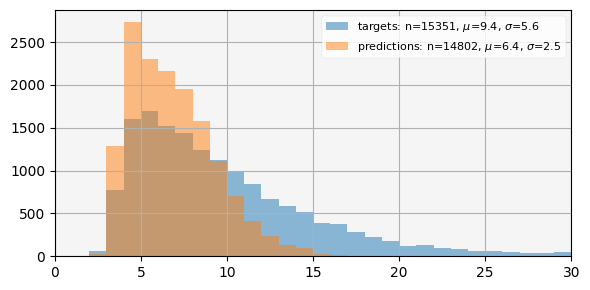

In [199]:
# Average length of ALL samples in the trial

fig, ax=plt.subplots(figsize=(6,3))
bins=np.linspace(0, 30, 31)

selectors = ['target_fact', 'pred_fact']
columns = ['labelwords', 'predictionwords']
labels = ['targets', 'predictions']

with plt.style.context('seaborn-v0_8-paper'):
    for selector, col, label in zip(selectors, columns, labels):
        data = df[df[selector] == 1][col]
        df[df[selector] == 1].hist(column=col, bins=bins, ax=ax, alpha=0.5, label=f"{label}: n={data.count()}, $\mu$={data.mean():.1f}, $\sigma$={data.std():.1f}")

    ax.set_facecolor('whitesmoke')
    ax.set_title('')
    ax.set_xlim(0,30)
    ax.legend()
    fig.tight_layout()

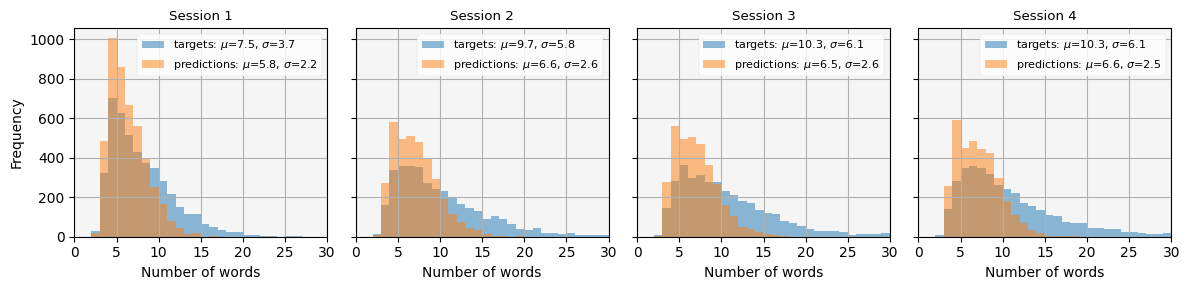

In [200]:
# Average length of predictions and targets, per session

fig, axs=plt.subplots(ncols=4, figsize=(12,3), sharey=True)
bins=np.linspace(0, 30, 31)

selectors = ['target_fact', 'pred_fact']
columns = ['labelwords', 'predictionwords']
labels = ['targets', 'predictions']

with plt.style.context('seaborn-v0_8-paper'):
    for session, ax in zip([1, 2, 3, 4], axs):
        selection = df['session'] == session
        for selector, col, label in zip(selectors, columns, labels):
            data = df[selection & (df[selector] == 1)][col]
            df[selection & (df[selector] == 1)].hist(column=col, bins=bins, ax=ax, alpha=0.5, label=f"{label}: $\mu$={data.mean():.1f}, $\sigma$={data.std():.1f}")

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"Session {session}")
        ax.set_xlim(0,30)
        ax.set_xlabel("Number of words")
        ax.legend()
        if session == 1:
            ax.set_ylabel("Frequency")

    fig.tight_layout()
plt.savefig('../docs/msc_turns_length.pdf', dpi=300, format='pdf', bbox_inches='tight')

### Classification

Text(0.5, 0.98, 'Accuracy of predicted facts, per session')

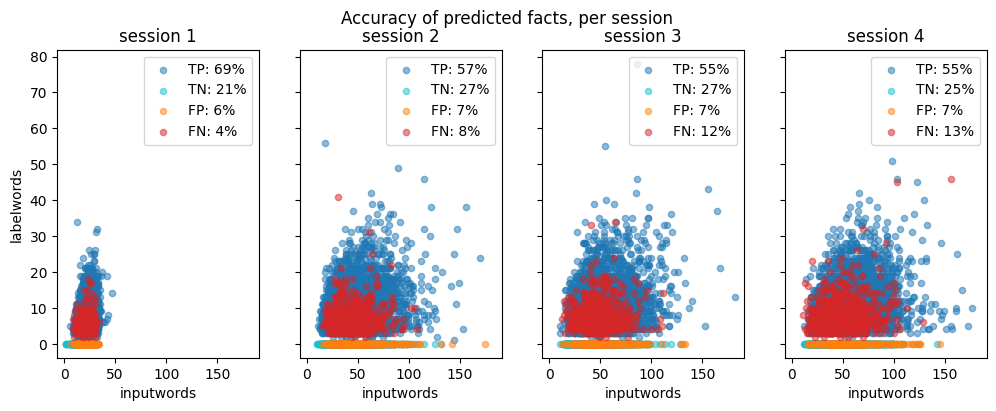

In [201]:
sessions = df['session'].unique()
fig, ax = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True, sharex=True)


selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
for i, session in enumerate(sessions):
    selected_session = df['session'] == session
    total = len(df[selected_session])
    for s in selection.keys():
        count = len(df[selected_session & selection[s]])
        label = f"{s}: {count/total:.0%}"
        df[selected_session & selection[s]].plot.scatter('inputwords', 'labelwords', c=col[s], alpha=0.5, label=label, ax=ax[i])
    ax[i].set_title(f"session {session}")

fig.suptitle("Accuracy of predicted facts, per session")

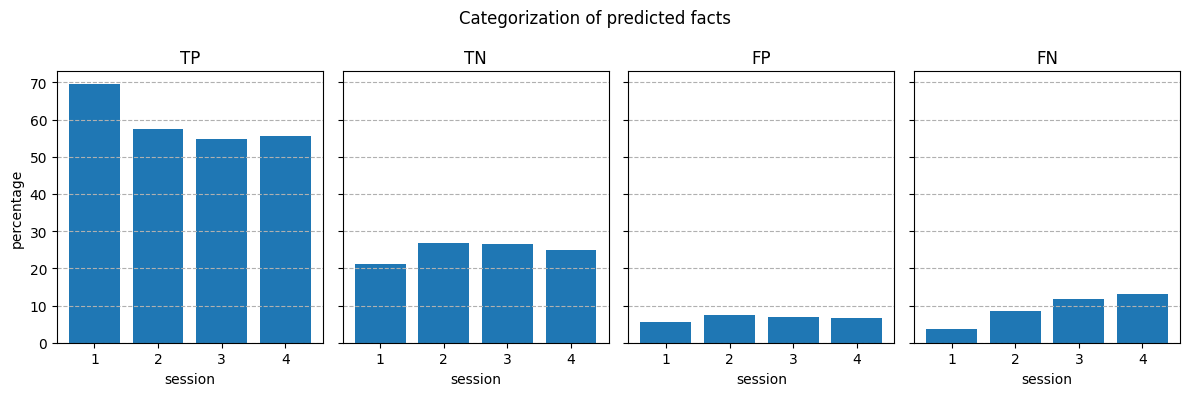

In [202]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
fig, ax = plt.subplots(ncols=len(selection.keys()), figsize=(12,4), sharey=True, sharex=True)

session_total = df.groupby(['session'])['turn_id'].count().values

for i, s in enumerate(selection.keys()):
    category_count = df[selection[s]].groupby(['session'])['turn_id'].count()
    perc = category_count / session_total * 100
    ax[i].bar(x=sessions, height=perc)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(s)
    ax[i].set_xticks(sessions)
    ax[i].set_xlabel("session")
    if i == 0:
        ax[i].set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts")
fig.tight_layout()

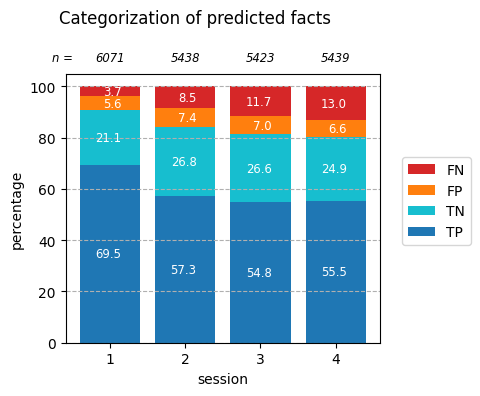

In [203]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
fig, ax = plt.subplots(figsize=(4,4))

session_total = df.groupby(['session'])['turn_id'].count().values
bottom = np.zeros(len(selection.keys()))

for s in selection.keys():
    category_count = df[selection[s]].groupby(['session'])['turn_id'].count().values
    perc = category_count / session_total * 100
    ax.bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
    for session, b, p in zip(sessions, bottom, perc):
        ax.text(session + 0.15, b + p/2, f"{p:.1f}", horizontalalignment='right', verticalalignment='center', fontsize='small', c='w')
    bottom += perc

ax.text(0.5, 110, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
for session, t in zip(sessions, session_total):
    ax.text(session, 110, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(sessions)
ax.set_xlabel("session")
ax.set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
fig.tight_layout()

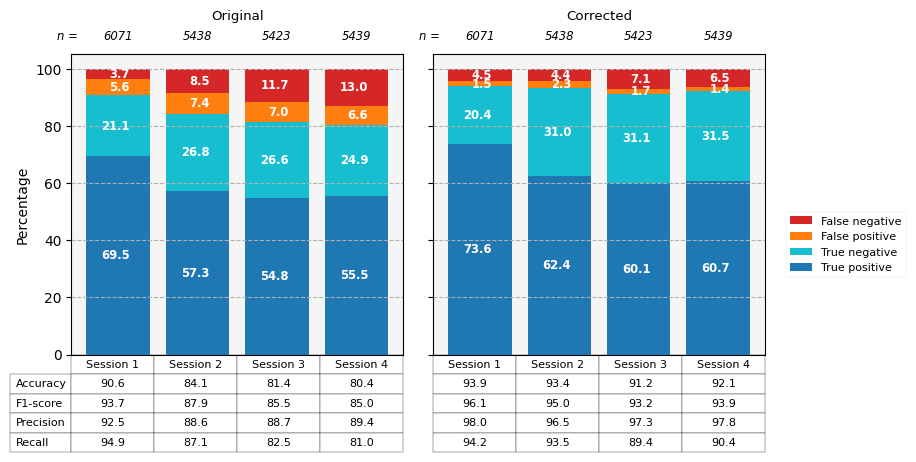

In [204]:
sessions = df['session'].unique()

# Below are the findings from review of a sample of 344 predictions. 
# These were checked to confirm if the annotated facts were indeed correct, but also if dialogues where no fact was annotated was correct
# This leads to a correction of the TP, TN, FP, FN categories.capitalize
# The array below is ordered per session, original label (TP, TN, FP, FN), revised label (TP, TN, FP, FN)
# For example, for session 3, there are 16 FP's that are in fact TP, and 5 FP's are correctly labeled as FP.
review = np.array([
    [[27, 0, 0, 0],
     [0, 19, 0, 1],
     [8, 0, 3, 0],
     [0, 1, 0, 13]],
    [[15, 0, 0, 0], 
     [0, 27, 0, 1],
     [20, 0, 9, 0],
     [0, 12, 0, 8]],
    [[24, 0, 0, 0],
     [0, 17, 0, 0],
     [16, 0, 5, 0],
     [0, 7, 0, 11]],
    [[24, 0, 0, 0],
     [0, 23, 0, 2],
     [15, 0, 4, 0],
     [0, 21, 0, 11]],
])
correction_matrix = np.array([
    review[s] / review[s].sum(axis=1).reshape(-1, 1)
    for s in range(4)
])

selection = {}
selection["True positive"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["True negative"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["False positive"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["False negative"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "True positive": 'tab:blue',
    "True negative": 'tab:cyan',
    "False positive": 'tab:orange',
    "False negative": 'tab:red'
}


session_total = df.groupby(['session'])['turn_id'].count().values
original_counts = np.array([
    df[selection[s]].groupby(['session'])['turn_id'].count().values
    for s in selection.keys()
])
corrected_counts = np.array([
    original_counts[:,s] @ correction_matrix[s]
    for s in range(4)
]).T

chart_data = np.array([original_counts, corrected_counts])
titles = ["Original", "Corrected"]

fig, axs = plt.subplots(ncols=2, figsize=(8,5), sharey=True)
with plt.style.context('seaborn-v0_8-paper'):
    for dataset, ax in zip(range(2), axs):

        bottom = np.zeros(len(selection.keys()))
        for i, s in enumerate(selection.keys()):
            perc = chart_data[dataset][i] / session_total * 100
            ax.bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
            for session, b, p in zip(sessions, bottom, perc):
                ax.text(session + 0.15, b + p/2, f"{p:.1f}", horizontalalignment='right', verticalalignment='center', fontsize='small', fontweight='bold', c='w')
            bottom += perc


        # Plot a table with Accuracy, F1, Precision, Recall
        acc = (chart_data[dataset][0] + chart_data[dataset][1]) / sum(chart_data[dataset])
        prec = chart_data[dataset][0] / (chart_data[dataset][0] + chart_data[dataset][2])
        rec = chart_data[dataset][0] / (chart_data[dataset][0] + chart_data[dataset][3])
        f1 = [(2 * p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(prec, rec)]
        ax_table = ax.table(
            cellText=np.round(np.array([acc, f1, prec, rec]) * 100, 1),
            colLabels=[f"Session {s}" for s in sessions],
            rowLabels=["Accuracy", "F1-score", "Precision", "Recall"] if dataset == 0 else None,
            cellLoc='center',
            loc='bottom',
        )
        ax_table.scale(1, 1.5)
        # ax_table.auto_set_font_size(False)
        # ax_table.set_fontsize(10)

        ax.set_facecolor('whitesmoke')
        ax.set_title(titles[dataset], pad=25)
        ax.text(0.5, 110, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        for session, t in zip(sessions, session_total):
            ax.text(session, 110, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
        ax.grid(which='major', axis='y', linestyle='--')
        # ax.set_xticks(sessions)
        # ax.set_xlabel("Session")
        ax.set_xticks([])
        if dataset == 0:
            ax.set_ylabel("Percentage")

    # fig.suptitle("Categorization of predicted facts")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    # fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    fig.tight_layout()
    plt.savefig('../docs/msc_turns_accuracy.pdf', dpi=300, format='pdf', bbox_inches='tight')

Session total:  [82  2  0  0]
Session total:  [2056  216  134  118]
Session total:  [3683  810  595  520]
Session total:  [ 246 1204 1109  999]
Session total:  [   4 1190 1171 1139]
Session total:  [   0  871 1009  940]
Session total:  [   0  838 1025 1161]
Session total:  [  0 231 290 416]
Session total:  [  0  76  90 146]


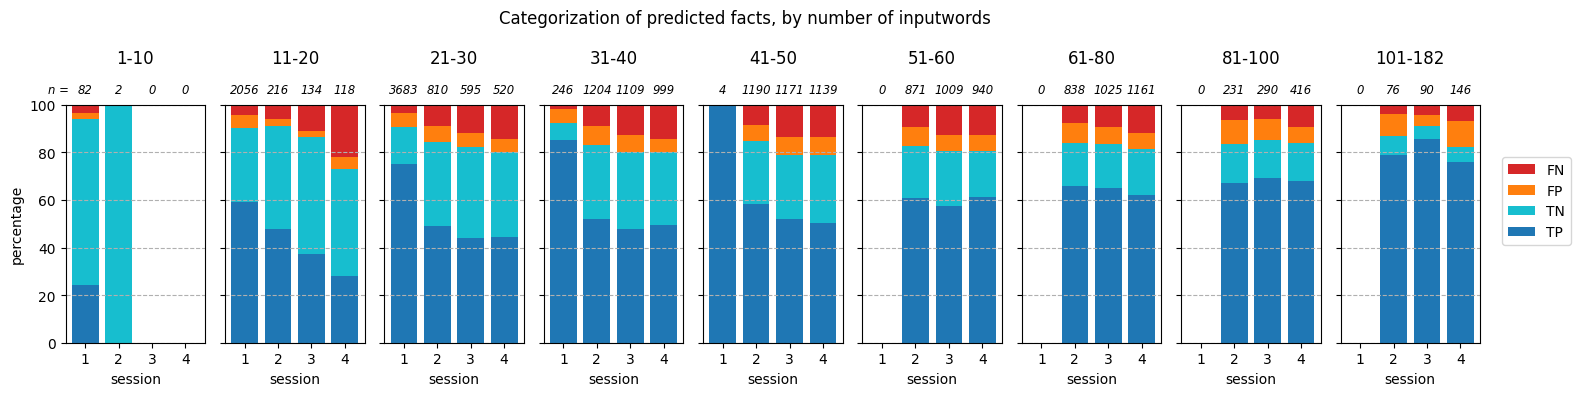

In [205]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
max_inputwords = df['inputwords'].max()
bin_boundaries = [0, 10, 20, 30, 40, 50, 60, 80, 100, max_inputwords]
# bin_boundaries = [0, 20, 40, 200]
bins = [(lower + 1, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, ax = plt.subplots(ncols=len(bins), figsize=(15, 4), sharey=True)


for i, (lower, upper) in enumerate(bins):
    selected_bin = (df['inputwords'] >= lower) & (df['inputwords'] <= upper)
    session_total = np.array([len(df[selected_bin & (df['session'] == session)]) for session in sessions])
    print("Session total: ", session_total)
    bottom = np.zeros(len(selection.keys()))

    for s in selection.keys():
        category_count = np.array([len(df[selected_bin & selection[s] & (df['session'] == session)]) for session in sessions])
        # print("Category count: ", category_count)
        perc = category_count / np.maximum(session_total, np.ones_like(session_total)) * 100
        ax[i].bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
        bottom += perc

    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"{lower}-{upper}", pad=30)
    for s, t in enumerate(session_total):
        ax[i].text(s + 1, 105, session_total[s], horizontalalignment='center', fontsize='small', fontstyle='italic')
    ax[i].set_xticks(sessions)
    ax[i].set_xlabel("session")
    if i == 0:
        ax[i].text(0.5, 105, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        ax[i].set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts, by number of inputwords")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
fig.tight_layout()

### TERp

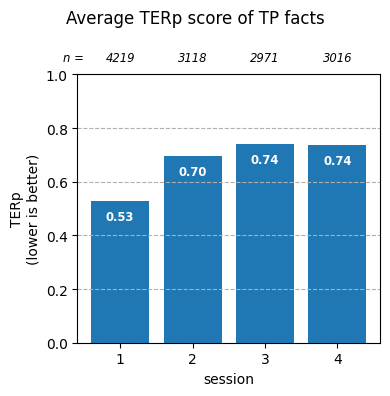

In [206]:
# TERp between prediction and target, average for all samples

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, ax = plt.subplots(figsize=(4,4))

terp_mean = df[selection["TP"]].groupby(['session'])['terp'].mean().values
terp_count =  df[selection["TP"]].groupby(['session'])['terp'].count().values

ax.bar(x=sessions, height=terp_mean)
for session, m in zip(sessions, terp_mean):
    ax.text(session, m - 0.07, f"{m:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

ax.text(0.5, 1.05, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
for session, t in zip(sessions, terp_count):
    ax.text(session, 1.05, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(sessions)
ax.set_xlabel("session")
ax.set_ylim(0,1)
ax.set_ylabel("TERp\n(lower is better)")

fig.suptitle("Average TERp score of TP facts")
fig.tight_layout()

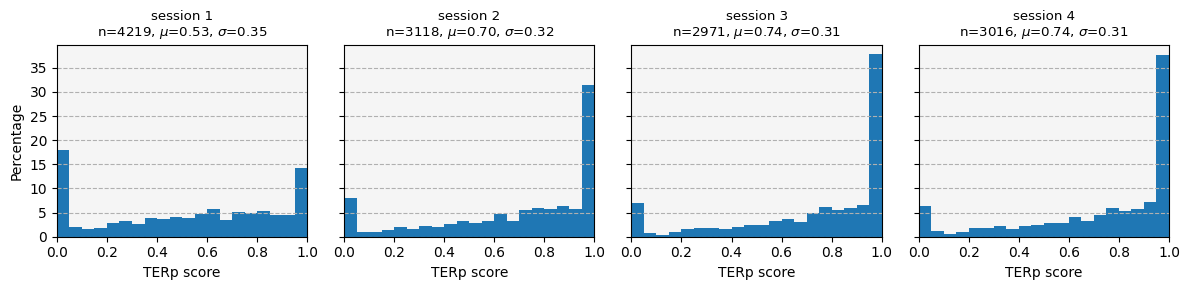

In [207]:
# TERp between prediction and target, per session

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,3), sharey=True)

with plt.style.context('seaborn-v0_8-paper'):
    for session, ax in zip(sessions, axs):

        df_subset = df[selection["TP"] & (df['session'] == session)]['terp']
        terp_mean = df_subset.mean()
        terp_std = df_subset.std()
        terp_count =  df_subset.count()

        ax.hist(df_subset, bins=20, range=(0,1), density=True)

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"session {session}\nn={terp_count}, " + r"$\mu$" + f"={terp_mean:.2f}, " + r"$\sigma$" + f"={terp_std:.2f}")
        ax.grid(which='major', axis='y', linestyle='--')
        ax.set_xlim(0,1)
        ax.set_xlabel("TERp score")
        if session == 1:
            ax.set_yticks(np.array(range(11)))
            ax.set_yticklabels(np.array(range(11))*5)
            ax.set_ylabel("Percentage")

    # fig.suptitle("Distribution of TERp scores of TP facts")
    fig.tight_layout()
    plt.savefig('../docs/msc_turns_terp_per_session.pdf', dpi=300, format='pdf', bbox_inches='tight')

In [208]:
# Example of low TERp scores (low=good)
df.sort_values(by=['terp'])[['target_persona', 'pred_persona', 'terp']].head(10)

target_persona  \
1 468 6                         I have three kids.   
  173 10                 I just started a new job.   
3 389 10                         I play the flute.   
1 173 2   I was on the debate team in high school.   
  386 7                     I live near the beach.   
  172 6                             I have 2 kids.   
2 158 7                 I have a son and a sister.   
3 397 0                  I have a pet named Tasha.   
      1                      I only speak English.   
2 157 9            My last dog was a rescued mutt.   

                                      pred_persona  terp  
1 468 6                         I have three kids.   0.0  
  173 10                 I just started a new job.   0.0  
3 389 10                         I play the flute.   0.0  
1 173 2   I was on the debate team in high school.   0.0  
  386 7                     I live near the beach.   0.0  
  172 6                             I have 2 kids.   0.0  
2 158 7                 I have a son and a sister.   0.0  
3 397 0                  I have a pet named Tasha.   0.0  
      1                      I only speak English.   0.0  
2 157 9             My last dog was a rescue mutt.   0.0

In [209]:
# Example of high TERp scores (low=good)
df.sort_values(by=['terp'], ascending=False)[['target_persona', 'pred_persona', 'terp']].head(10)

target_persona  \
3 440 4                  I test items on my mother's menu.   
2 470 6  I don't have a gym membership. I go swimming o...   
  473 4                   I went skydiving in Napa Valley.   
      2  This was my first time skydiving, and I was sc...   
4 279 4  I think (speaker 1) should get a Lab. I think ...   
2 473 0  I have a gecko. I did not take my gecko skydiv...   
  472 9  I find the ocean peaceful and inspirational. I...   
1 339 5        I stay at home and attend college at devry.   
2 472 8       My mom's shop is a short walk from downtown.   
      4                         My mom owns a coffee shop.   

                                pred_persona  terp  
3 440 4  I am not creative. I enjoy cooking.   1.0  
2 470 6                 I do not swim often.   1.0  
  473 4       I was scared of landing badly.   1.0  
      2                      I have a gecko.   1.0  
4 279 4                        I have a Lab.   1.0  
2 473 0                     I have a lizard.   1.0  
  472 9                    I like the beach.   1.0  
1 339 5         I am studying online, devry.   1.0  
2 472 8                  I live in downtown.   1.0  
      4      I like pastries and sandwiches.   1.0

In [210]:
# Sample a number of TERp scores within a predefined range
# Translate the output to latex table

selection = (df['terp'] >= 0.95) & (df['session'] != 1) #& (df['terp'] <= 0.75) 
table_df = df[selection][['history', 'target_persona', 'pred_persona', 'terp']].sample(10).sort_values(by=['terp'])
table_df.set_index(['history'], inplace=True)  #['target_persona', 'pred_persona'],inplace=True)
s = table_df.style.format({
    'terp': '{:.2f}', 
})
print(s.to_latex(hrules=True, clines="all;data").replace('<sep>', '\\texttt{<sep>}'))
s

\begin{tabular}{lllr}
\toprule
 & target_persona & pred_persona & terp \\
history &  &  &  \\
\midrule
I was just thinking about your schedule. I am still in the creative zone so my schedule is fluid at the moment. Are you free this Tuesday. I have the whole day free.\texttt{<sep>}I would be free Tuesday evening after work, I think. I would just need a little time to go home and clean up a little, first. Also, I've been wanting to ask, but have you eaten any specialty meats lately? & I am free Tuesday evening after work. & I have a job. & 0.99 \\
\cline{1-4}
Great I'll send that one over as well as a few others.  How is the surfing?\texttt{<sep>}Loving it. I've already been out today and the waves were great. You really should come visit sometime and I could give you some lessons, I think you'd really enjoy it. & I have spent some time surfing today. I love to surf. & I enjoy surfing. & 0.99 \\
\cline{1-4}
Did you visit that one tree that you can drive through?\texttt{<sep>}I did not. 

,target_persona,pred_persona,terp
history,,,
"I was just thinking about your schedule. I am still in the creative zone so my schedule is fluid at the moment. Are you free this Tuesday. I have the whole day free.I would be free Tuesday evening after work, I think. I would just need a little time to go home and clean up a little, first. Also, I've been wanting to ask, but have you eaten any specialty meats lately?",I am free Tuesday evening after work.,I have a job.,0.99
"Great I'll send that one over as well as a few others. How is the surfing?Loving it. I've already been out today and the waves were great. You really should come visit sometime and I could give you some lessons, I think you'd really enjoy it.",I have spent some time surfing today. I love to surf.,I enjoy surfing.,0.99
Did you visit that one tree that you can drive through?I did not. Please let me know if you do!,I want to know more about the tree that can be driven through.,I do not drive through a tree.,0.99
"No it's nasty! What made you decide to be vegan?Weight control, health problems. I felt a lot better after going vegan. More Americans should try it to manage their health. I didn't realize how bad my diet was until I changed.",I had weight-related health problems.,I am a vegan.,1.00
"honestly so much comes down to camera! I bet you're as good as I am when it comes to angles or knowing what to do -- the camera is what makes the picture fancy, not my skills, lol. do you use a phone camera or do you like to use a real camera for pics?I use my phone, don't take enough pictures for a real camera. If I took better pictures I would post more on social media lol",I don't take enough pictures to have a real camera. I use my phone to take pictures. If I took more pictures I would post more on social media.,I have a phone.,1.00
Fresh basil is my favorite! It tastes so good and you can use it for so much. Garlic broccoli is very good though but I prefer my broccoli seared and sautéd. Do you have any experience growing these plants?I have never tried the broccoli but my mom has although she likes to harvest early so she starts them indoors. She is going to teach me so I can gain so I can gain some experience. I have grown my own chickpeas for the first time this last year so that was exciting.,I am going to learn to grow food from my mom. I grew my own chickpeas for the first time last year. My mom grows broccoli and harvests it early.,I have a mom. I have grown chickpeas.,1.00
"Have you competed in any League of Legends tournaments?No, but I've thought about it before. I don't know if I'm good enough to do very well just yet, haha. Have any of your other friends done it?",I've thought about competing in League of Legend tournaments but I'm not sure I'm good enough.,I am not good at League of Legends.,1.00
"I also have an Asian supermarket near me, that is why love cooking Thai recipes, otherwise I would always be changing the ingredients in my recipes. What is you favorite ingredient ?It's hard to pick a favourite ingredient. I just love how fresh and flavourful Thai food is. What about you, do you have a favourite ingredient?",it's very to hard to find favorite ingredient.,I love Thai food.,1.00
They are just about to enter their teenage years (11 and 12). I'm hoping that they continue to love Disney as much as I do. I would love to see something from the Lion King on Ice. I saw it on Broadway with both my kids and they were in love. The costumes were fabulous.I saw the Lion King on Broadway too! NYC Broadway show a few years back. It was breathtaking. I loved the costumes and their singing. So powerful!,I visited NYC Broadway. I have been to New York City.,I saw the Lion King on Broadway a few years back.,1.00


In [211]:
# Calculate what share of the samples has a TERp score within a predefined range

selection = (df['terp'] >= 0) & (df['terp'] <= 0.75) & (df['session'] == 1)
good_terp = df[selection]['terp'].count()
total = df[(df['terp'] >= 0)  & (df['session'] == 1)]['terp'].count()
print(good_terp, total, good_terp/total)


2809 4219 0.6657975823654895


### NLI-score

In [212]:
print("NLI prediction to target: ", df[(df['pred_fact'] == 1) & (df['target_fact'] == 1) ]['nli_pred_to_target'].mean())
print("NLI input to prediction: ", df[df['pred_fact'] == 1]['nli_pred'].mean())

NLI prediction to target:  0.368283513344371
NLI input to prediction:  0.7800117275998616


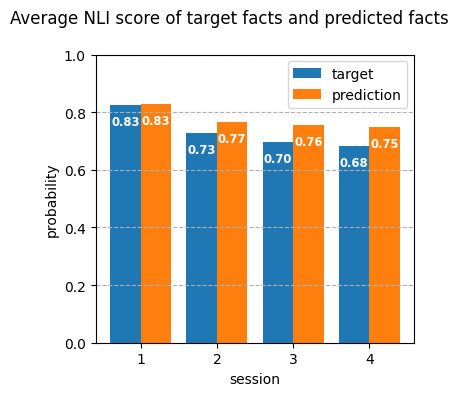

In [213]:
# All NLI scores from input to target, input to prediction; per session

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, ax = plt.subplots(figsize=(4,4))

nli_target_mean = df[df['target_fact'] == 1].groupby(['session'])['nli_target'].mean().values
nli_pred_mean = df[df['pred_fact'] == 1].groupby(['session'])['nli_pred'].mean().values

ax.bar(x=sessions - 0.2, height=nli_target_mean, width=0.4, label="target")
ax.bar(x=sessions + 0.2, height=nli_pred_mean, width=0.4, label="prediction")
for session, m in zip(sessions, nli_target_mean):
    ax.text(session - 0.2, m - 0.07, f"{m:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')
for session, m in zip(sessions, nli_pred_mean):
    ax.text(session + 0.2, m - 0.07, f"{m:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

ax.legend()
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(sessions)
ax.set_xlabel("session")
ax.set_ylim(0,1)
ax.set_ylabel("probability")

fig.suptitle("Average NLI score of target facts and predicted facts")
fig.tight_layout()

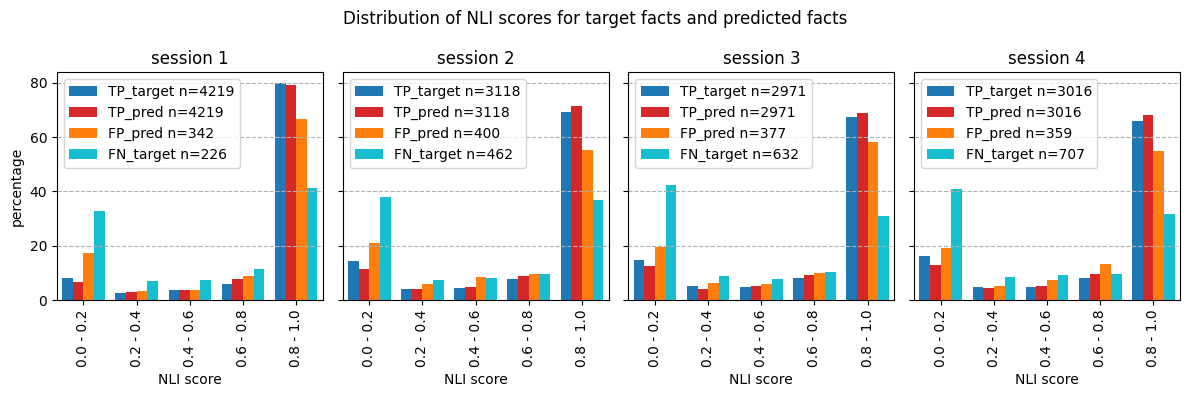

In [214]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}

bin_boundaries = [0, 0.2, 0.4, 0.6, 0.8, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    for i, s in enumerate(colors.keys()):
        df_subset = df[selection[s[:2]] & (df['session'] == session)]
        nli_col = 'nli' + s[2:]
        num_perbin = np.array([
            df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].count()
            for lower, upper in bins
        ])
        num_total =  sum(num_perbin)

        ax.bar(x=x_range+0.2+i*0.2, height=num_perbin/num_total*100, color=colors[s], width=0.2, label=f"{s} n={num_total}")

    ax.set_title(f"session {session}")
    ax.legend()
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0, len(bins))
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_xticks(x_range + 0.5)
    ax.set_xticklabels(f"{lower:.1f} - {upper:.1f}" for lower, upper in bins)
    ax.set_xlabel("NLI score")
    if session == 1:
        # ax.set_yticks(np.array(range(21)))
        # ax.set_yticklabels(np.array(range(21))*2)
        ax.set_ylabel("percentage")

fig.suptitle("Distribution of NLI scores for target facts and predicted facts")
fig.tight_layout()

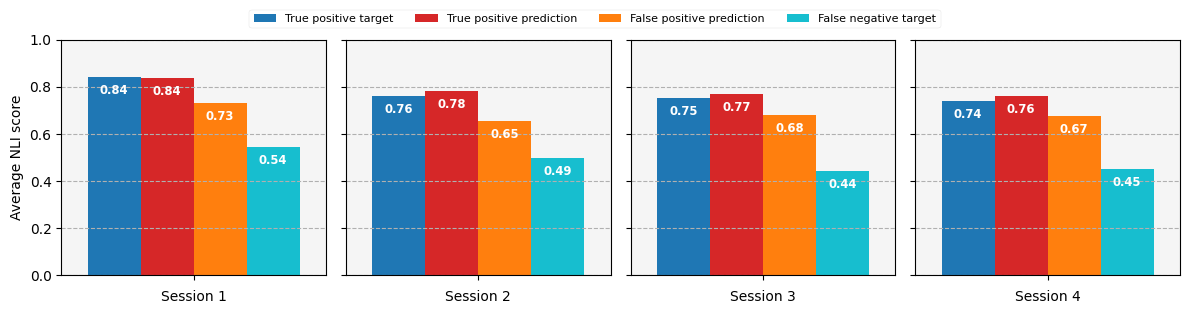

In [221]:
# NLI scores for the four classification categories; per session

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,3), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}
labels = {
    "TP_target": "True positive target",
    "TP_pred": "True positive prediction",
    "FP_pred": "False positive prediction", 
    "FN_target": "False negative target",
}

bin_boundaries = [0, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

with plt.style.context('seaborn-v0_8-paper'):
    for session, ax in zip(sessions, axs):

        for i, s in enumerate(colors.keys()):
            df_subset = df[selection[s[:2]] & (df['session'] == session)]
            nli_col = 'nli' + s[2:]
            avg_perbin = np.array([
                df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].mean()
                for lower, upper in bins
            ])
            std_perbin = np.array([
                df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].std()
                for lower, upper in bins
            ])
            x_range_bin = x_range+0.2+i*0.2
            ax.bar(x=x_range_bin, height=avg_perbin, 
                #    yerr=std_perbin, 
                color=colors[s], width=0.2, label=f"{labels[s]}")
            ax.text(x_range_bin[0], avg_perbin - 0.07, f"{avg_perbin[0]:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

        ax.set_facecolor('whitesmoke')
        ax.set_xlabel(f"Session {session}")
        ax.grid(which='major', axis='y', linestyle='--')
        ax.set_xlim(0, len(bins))
        ax.set_xticks(x_range + 0.5)
        ax.set_xticklabels("")
        if session == 1:
            ax.set_ylim(0,1)
            ax.set_ylabel("Average NLI score")

    # fig.suptitle("Average NLI scores for target facts and predicted facts, per session")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=4)
    fig.tight_layout()
    plt.savefig('../docs/msc_turns_nli_per_session.pdf', dpi=300, format='pdf', bbox_inches='tight')

In [ ]:
# Violinplot with NLI scores per category, per session

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}

bin_boundaries = [0, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    data = [
        df[selection[s[:2]] & (df['session'] == session)]['nli' + s[2:]].values
        for s in colors.keys()
    ]

    plots = ax.violinplot(data, showmeans=True, widths=0.9)

    for pc, color in zip(plots['bodies'], colors.values()):
        pc.set_facecolor(color)
        pc.set_alpha(1)
    ax.set_xlabel(f"session {session}")
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(colors.keys())
    ax.grid(which='major', axis='y', linestyle='--')
    if session == 1:
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel("Average NLI score")

fig.suptitle("Distribution of NLI scores for target facts and predicted facts, per session")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [ ]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}
fig, ax = plt.subplots(ncols=3, figsize=(9,4), sharey=True)

for s, a in zip(["TP", "FN", "FP"], ax):

    if s == 'TP' or s == 'FN':
        nli_tgt_mean = df[selection[s]].groupby(['session'])['nli_target'].mean().values
        count = df[selection[s]].groupby(['session'])['nli_target'].count().values
        a.bar(x=sessions - 0.2, height=nli_tgt_mean, width=0.4, color=colors[f"{s}_target"], label=f"{s}_target")
        for session, m in zip(sessions, nli_tgt_mean):
            a.text(session - 0.2, m - 0.07, (f"{m:.2f}")[1:], horizontalalignment='center', fontweight='bold', fontsize='small', c='w')
    if s == 'TP' or s == 'FP':
        nli_pred_mean = df[selection[s]].groupby(['session'])['nli_pred'].mean().values
        count = df[selection[s]].groupby(['session'])['nli_pred'].count().values
        a.bar(x=sessions + 0.2, height=nli_pred_mean, width=0.4, color=colors[f"{s}_pred"], label=f"{s}_pred")
        for session, m in zip(sessions, nli_pred_mean):
            a.text(session + 0.2, m - 0.07, (f"{m:.2f}")[1:], horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

    for session, t in zip(sessions, count):
        a.text(session, 1.05, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
    a.set_title(s, pad=30)
    a.grid(which='major', axis='y', linestyle='--')
    a.set_xlim(0.5, 4.5)
    a.set_xticks(sessions)
    a.set_xlabel("session")
    if s == "TP":
        a.text(0.5, 1.05, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        a.set_ylabel("probability\nof entailment")
        a.set_ylim(0, 1)
    
fig.suptitle("Average NLI probability of entailment for targets and predictions")
# handles, labels = ax[0].get_legend_handles_labels()
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

### Correlation NLI-score and TERp

In [ ]:
# relation between NLI score and TERp score

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

bin_boundaries = np.linspace(0, 1.0, num=11)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    nli_col = 'nli_pred'
    num_perbin = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].count()
        for lower, upper in bins
    ])
    num_total = sum(num_perbin)
    avg_terp = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)]['terp'].mean()
        for lower, upper in bins
    ])
    print(session, avg_terp, num_perbin)

    ax.scatter(bin_boundaries[:-1] + 0.05, avg_terp, s=num_perbin)

    # ax.set_title(f"session {session}")
    # ax.legend()
    # ax.grid(which='major', axis='y', linestyle='--')
    # ax.set_xlim(0, len(bins))
    # ax.tick_params(axis='x', labelrotation = 90)
    # ax.set_xticks(x_range + 0.5)
    # ax.set_xticklabels(f"{lower:.1f} - {upper:.1f}" for lower, upper in bins)
    # ax.set_xlabel("NLI score")
    # if session == 1:
    #     # ax.set_yticks(np.array(range(21)))
    #     # ax.set_yticklabels(np.array(range(21))*2)
    #     ax.set_ylabel("percentage")

fig.suptitle("Distribution of NLI scores for target facts and predicted facts")
fig.tight_layout()

In [ ]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()

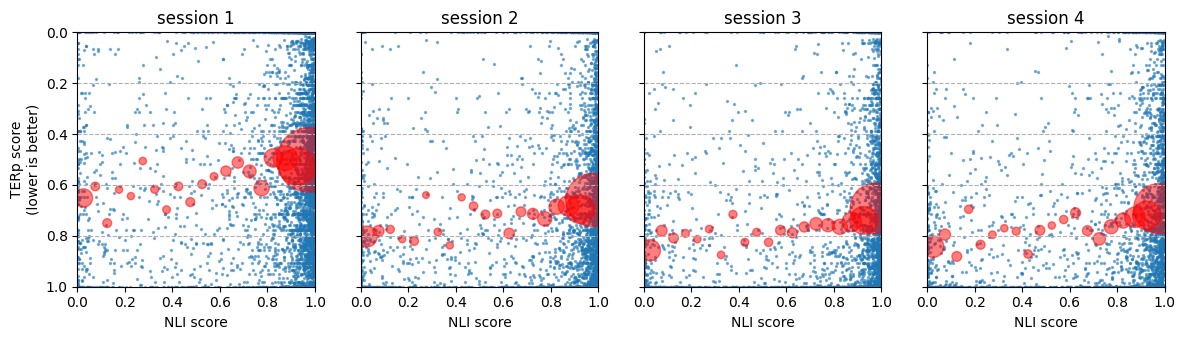

In [223]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

num_bins = 20
bin_boundaries = np.linspace(0, 1.0, num=num_bins+1)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,3.5), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)

    # Calculate average per 'bin' and add it to scatter chart
    nli_col = 'nli_pred'
    num_perbin = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].count()
        for lower, upper in bins
    ])
    avg_terp = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)]['terp'].mean()
        for lower, upper in bins
    ])
    ax.scatter(bin_boundaries[:-1] + 0.5/num_bins, avg_terp, s=num_perbin, c='r', alpha=0.5)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

# fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()
plt.savefig('../docs/msc_turns_nli_terp.pdf', dpi=300, format='pdf', bbox_inches='tight')

In [ ]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

num_bins = 20
bin_boundaries = np.linspace(0, 1.0, num=num_bins+1)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)
    corr = df_subset[['nli_pred', 'terp']].corr().values[0,1]
    # print(corr)
    
    # Calculate average per 'bin' and add it to scatter chart
    terp_data = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)]['terp'].agg(['mean', 'std', 'count'])
        for lower, upper in bins
    ])
    ax.scatter(bin_boundaries[:-1] + 0.5/num_bins, terp_data[:, 0], s=terp_data[:, 2], c='r', alpha=0.5)
    ax.fill_between(bin_boundaries[:-1] + 0.5/num_bins, y1=terp_data[:, 0] - terp_data[:, 1], y2=terp_data[:, 0] + terp_data[:, 1], alpha=0.3)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()

In [ ]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

num_bins = 20
bin_boundaries = np.linspace(0, 1.01, num=num_bins+1)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)
    corr = df_subset[['nli_pred', 'terp']].corr().values[0,1]
    # print(corr)
    
    # Calculate average per 'bin' and add it to scatter chart
    nli_data = np.array([
        df_subset[(df_subset['terp'] >= lower) & (df_subset['terp'] < upper)][nli_col].agg(['mean', 'std', 'count'])
        for lower, upper in bins
    ])
    ax.scatter(nli_data[:, 0], bin_boundaries[:-1] + 0.5/num_bins,  s=nli_data[:, 2], c='r', alpha=0.5)
    # ax.fill_between(bin_boundaries[:-1] + 0.5/num_bins, y1=terp_data[:, 0] - terp_data[:, 1], y2=terp_data[:, 0] + terp_data[:, 1], alpha=0.3)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()
plt.savefig('../docs/msc_turns_terp_nli.pdf', dpi=300, format='pdf', bbox_inches='tight')

## Evaluation of Summaries

### First adjust table name/columns!

In [103]:
# Helper functions

def format_gen_config(settings):
    # settings contains: do_sample, num_beams, temp, top_p, top_k
    if settings[0] == False:
        return "Greedy"
    else:
        if settings[1] == 1 and settings[2] == 1.0 and settings[3] == 1.0 and settings[4] == 0:
            return "Unbiased sampling"
        elif settings[1] == 5 and settings[2] == 1.0 and settings[3] == 0.9 and settings[4] == 10:
            return "Narrow beam"
        elif settings[1] == 5 and settings[2] == 1.5 and settings[3] == 0.9 and settings[4] == 10:
            return "Flat-Narrow beam"
        elif settings[1] == 5 and settings[2] == 1.5 and settings[3] == 0.9 and settings[4] == 50:
            return "Flat-Broad beam"
        else:
            return f"b={int(settings[1])}, t={settings[2]:.1f}, top_p={settings[3]:.1f}, top_k={int(settings[4])}"

In [104]:
all_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, trained_nll05_bart_20230722_025739 to trained_nll05_bart_20230807_004034
Data columns (total 85 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   eval_terp_f1               40 non-null     float64
 1   eval_terp_precision        40 non-null     float64
 2   eval_terp_recall           40 non-null     float64
 3   eval_terp_precstrength     40 non-null     float64
 4   eval_terp_recstrength      40 non-null     float64
 5   eval_nli_tp_f1             40 non-null     float64
 6   eval_nli_tp_precision      40 non-null     float64
 7   eval_nli_tp_recall         40 non-null     float64
 8   eval_nli_tp_precstrength   40 non-null     float64
 9   eval_nli_tp_recstrength    40 non-null     float64
 10  eval_nli_pt_f1             40 non-null     float64
 11  eval_nli_pt_precision      40 non-null     float64
 12  eval_nli_pt_recall         40 non-null     float

In [105]:
# Define the list of metrics and submetrics

# Change columns names so that 'prec_strength' can be identified as submetric
all_stats_df.columns = [c.replace('_strength', 'strength') for c in all_stats_df.columns]

submetrics = {}
for c in all_stats_df.columns:
    if c[:5] == 'eval_':
        c_split = c.split('_')
        metric = '_'.join(c_split[1:-1])
        submetric = c_split[-1]
        if not metric in submetrics.keys():
            submetrics[metric] = [submetric]
        else:
            submetrics[metric].append(submetric)
metrics = list(submetrics.keys())
metric_keys = [c for c in all_stats_df.columns if c[:5] == 'eval_']

print(metrics)
print(submetrics)
print(metric_keys)


['terp', 'nli_tp', 'nli_pt', 'nli_avg', 'numwords', 'numfacts', 'rougeL']
{'terp': ['f1', 'precision', 'recall', 'precstrength', 'recstrength'], 'nli_tp': ['f1', 'precision', 'recall', 'precstrength', 'recstrength'], 'nli_pt': ['f1', 'precision', 'recall', 'precstrength', 'recstrength'], 'nli_avg': ['f1', 'precision', 'recall', 'precstrength', 'recstrength'], 'numwords': ['factor'], 'numfacts': ['factor'], 'rougeL': ['fmeasure', 'precision', 'recall']}
['eval_terp_f1', 'eval_terp_precision', 'eval_terp_recall', 'eval_terp_precstrength', 'eval_terp_recstrength', 'eval_nli_tp_f1', 'eval_nli_tp_precision', 'eval_nli_tp_recall', 'eval_nli_tp_precstrength', 'eval_nli_tp_recstrength', 'eval_nli_pt_f1', 'eval_nli_pt_precision', 'eval_nli_pt_recall', 'eval_nli_pt_precstrength', 'eval_nli_pt_recstrength', 'eval_nli_avg_f1', 'eval_nli_avg_precision', 'eval_nli_avg_recall', 'eval_nli_avg_precstrength', 'eval_nli_avg_recstrength', 'eval_numwords_factor', 'eval_numfacts_factor', 'eval_rougeL_fmeasu

In [114]:
# Define the groupby columns
from pandas.api.types import CategoricalDtype

decoder_options = ['do_sample', 'num_beams', 'temperature', 'top_p', 'top_k']
gen_config_cat = CategoricalDtype(['Greedy', 'Unbiased sampling','Narrow beam', 'Flat-Narrow beam', 'Flat-Broad beam'], ordered=True)

In [116]:
all_stats_df['gen_config'] = all_stats_df[decoder_options].apply(format_gen_config, axis=1).astype(gen_config_cat)

In [174]:
# result_df = all_stats_df.groupby(by=decoder_options + ['session'])[metric_keys].agg(['mean', 'std'])
# result_df = all_stats_df.groupby(by=['session'] + decoder_options)[metric_keys].agg(['mean', 'std'])
result_df = all_stats_df.groupby(by=['session', 'gen_config'])[metric_keys].agg(['mean'])


newcolumns = pd.MultiIndex.from_tuples([(m, s, a) for m in metrics for s in submetrics[m] for a in ['mean']])
result_df.columns = newcolumns

result_df

terp                                   \
                                 f1 precision    recall precstrength   
                               mean      mean      mean         mean   
session gen_config                                                     
1       Greedy             0.661265  0.740941  0.620655     0.554336   
        Unbiased sampling  0.567433  0.616555  0.553908     0.440604   
        Narrow beam        0.670053  0.745385  0.630729     0.560065   
        Flat-Narrow beam   0.677868  0.736211  0.650833     0.554562   
        Flat-Broad beam    0.676381  0.723690  0.657587     0.538892   
2       Greedy             0.475796  0.596048  0.425400     0.422532   
        Unbiased sampling  0.364123  0.427877  0.344933     0.286836   
        Narrow beam        0.485778  0.616225  0.430024     0.436684   
        Flat-Narrow beam   0.490036  0.592189  0.448830     0.417314   
        Flat-Broad beam    0.477621  0.557674  0.449683     0.395282   
3       Greedy             0.461111  0.609534  0.399991     0.421938   
        Unbiased sampling  0.355869  0.437169  0.331281     0.284646   
        Narrow beam        0.465943  0.618370  0.402545     0.431571   
        Flat-Narrow beam   0.470923  0.591151  0.421618     0.410634   
        Flat-Broad beam    0.473452  0.573843  0.434452     0.394121   
4       Greedy             0.426309  0.566365  0.370886     0.400156   
        Unbiased sampling  0.313035  0.391099  0.293120     0.260471   
        Narrow beam        0.437594  0.577326  0.380045     0.414477   
        Flat-Narrow beam   0.453601  0.563829  0.409681     0.392506   
        Flat-Broad beam    0.454596  0.554517  0.417072     0.379455   

                                         nli_tp                      \
                          recstrength        f1 precision    recall   
                                 mean      mean      mean      mean   
session gen_config                                                    
1       Greedy               0.464741  0.666941  0.737268  0.628356   
        Unbiased sampling    0.395175  0.508805  0.551078  0.500545   
        Narrow beam          0.472712  0.664991  0.735365  0.626063   
        Flat-Narrow beam     0.491650  0.651928  0.701642  0.628648   
        Flat-Broad beam      0.491131  0.647949  0.686834  0.633404   
2       Greedy               0.302712  0.531296  0.629127  0.491939   
        Unbiased sampling    0.237431  0.351922  0.389197  0.356148   
        Narrow beam          0.308152  0.526588  0.629372  0.483062   
        Flat-Narrow beam     0.320485  0.506573  0.581152  0.480917   
        Flat-Broad beam      0.321447  0.502164  0.554584  0.495837   
3       Greedy               0.282396  0.469774  0.585983  0.420723   
        Unbiased sampling    0.220527  0.301438  0.352651  0.296550   
        Narrow beam          0.285756  0.467002  0.587147  0.416049   
        Flat-Narrow beam     0.298091  0.446006  0.537615  0.412416   
        Flat-Broad beam      0.301703  0.444011  0.514358  0.424867   
4       Greedy               0.260180  0.447595  0.565038  0.406096   
        Unbiased sampling    0.198229  0.270345  0.321886  0.268543   
        Narrow beam          0.269513  0.445161  0.567569  0.401267   
        Flat-Narrow beam     0.283045  0.423556  0.502316  0.400913   
        Flat-Broad beam      0.287364  0.422709  0.482131  0.410937   

                                                    ...   nli_avg            \
                          precstrength recstrength  ...        f1 precision   
                                  mean        mean  ...      mean      mean   
session gen_config                                  ...                       
1       Greedy                0.734670    0.628775  ...  0.552670  0.623774   
        Unbiased sampling     0.554433    0.505224  ...  0.423632  0.464997   
        Narrow beam           0.733190    0.625804  ...  0.560731  0.632760   
        Flat-Narrow beam      0.700682    0.

In [186]:
table_cols = pd.MultiIndex.from_product([['terp', 'nli_avg'], ['f1', 'precision', 'recall']])

# result_df.columns = result_df.columns.droplevel(2)
table_df = result_df[table_cols]
table_df = table_df.stack().stack()
table_df = table_df.unstack(0)
# table_df = table_df.unstack(2)
table_df = table_df.unstack(1)
table_df = table_df.reorder_levels([1,0], axis=0)
table_df = table_df.reindex([(m, c) for m in ['terp', 'nli_avg'] for c in list(gen_config_cat.categories) ], axis=0)
table_df = table_df.droplevel(0, axis=0)
# table_df = table_df.reindex([(s, m) for s in [1, 2, 3, 4] for m in ['terp', 'nli_avg']], axis=1)
table_df

session                   1                             2                      \
                         f1 precision    recall        f1 precision    recall   
gen_config                                                                      
Greedy             0.661265  0.740941  0.620655  0.475796  0.596048  0.425400   
Unbiased sampling  0.567433  0.616555  0.553908  0.364123  0.427877  0.344933   
Narrow beam        0.670053  0.745385  0.630729  0.485778  0.616225  0.430024   
Flat-Narrow beam   0.677868  0.736211  0.650833  0.490036  0.592189  0.448830   
Flat-Broad beam    0.676381  0.723690  0.657587  0.477621  0.557674  0.449683   
Greedy             0.552670  0.623774  0.512692  0.345645  0.436207  0.309555   
Unbiased sampling  0.423632  0.464997  0.409780  0.247988  0.284899  0.241578   
Narrow beam        0.560731  0.632760  0.520060  0.351081  0.448044  0.310389   
Flat-Narrow beam   0.566074  0.617087  0.540609  0.349212  0.417380  0.323184   
Flat-Broad beam    0.560032  0.601994  0.542002  0.345215  0.397298  0.332294   

session                   3                             4                      
                         f1 precision    recall        f1 precision    recall  
gen_config                                                                     
Greedy             0.461111  0.609534  0.399991  0.426309  0.566365  0.370886  
Unbiased sampling  0.355869  0.437169  0.331281  0.313035  0.391099  0.293120  
Narrow beam        0.465943  0.618370  0.402545  0.437594  0.577326  0.380045  
Flat-Narrow beam   0.470923  0.591151  0.421618  0.453601  0.563829  0.409681  
Flat-Broad beam    0.473452  0.573843  0.434452  0.454596  0.554517  0.417072  
Greedy             0.324142  0.437484  0.276416  0.297471  0.404061  0.255300  
Unbiased sampling  0.217490  0.272713  0.202968  0.188598  0.232411  0.178152  
Narrow beam        0.331235  0.450788  0.281802  0.301302  0.408908  0.258568  
Flat-Narrow beam   0.327863  0.416656  0.290516  0.303567  0.381323  0.273135  
Flat-Broad beam    0.328095  0.399155  0.301763  0.301157  0.364634  0.278656

In [188]:
s = table_df.style.format(precision=2)
print(s.to_latex(hrules=True).replace('f1', 'F1').replace('precision', 'P').replace('recall', 'R').replace('terp', 'TERp').replace('nli_avg', 'NLI').replace('gen_config', ''))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
session & \multicolumn{3}{r}{1} & \multicolumn{3}{r}{2} & \multicolumn{3}{r}{3} & \multicolumn{3}{r}{4} \\
 & F1 & P & R & F1 & P & R & F1 & P & R & F1 & P & R \\
 &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Greedy & 0.66 & 0.74 & 0.62 & 0.48 & 0.60 & 0.43 & 0.46 & 0.61 & 0.40 & 0.43 & 0.57 & 0.37 \\
Unbiased sampling & 0.57 & 0.62 & 0.55 & 0.36 & 0.43 & 0.34 & 0.36 & 0.44 & 0.33 & 0.31 & 0.39 & 0.29 \\
Narrow beam & 0.67 & 0.75 & 0.63 & 0.49 & 0.62 & 0.43 & 0.47 & 0.62 & 0.40 & 0.44 & 0.58 & 0.38 \\
Flat-Narrow beam & 0.68 & 0.74 & 0.65 & 0.49 & 0.59 & 0.45 & 0.47 & 0.59 & 0.42 & 0.45 & 0.56 & 0.41 \\
Flat-Broad beam & 0.68 & 0.72 & 0.66 & 0.48 & 0.56 & 0.45 & 0.47 & 0.57 & 0.43 & 0.45 & 0.55 & 0.42 \\
Greedy & 0.55 & 0.62 & 0.51 & 0.35 & 0.44 & 0.31 & 0.32 & 0.44 & 0.28 & 0.30 & 0.40 & 0.26 \\
Unbiased sampling & 0.42 & 0.46 & 0.41 & 0.25 & 0.28 & 0.24 & 0.22 & 0.27 & 0.20 & 0.19 & 0.23 & 0.18 \\
Narrow beam & 0.56 & 0.63 & 0.52 & 0.35 & 0.

In [120]:
# result_df = all_stats_df.groupby(by=decoder_options + ['session'])[metric_keys].agg(['mean', 'std'])
# result_df = all_stats_df.groupby(by=['session'] + decoder_options)[metric_keys].agg(['mean', 'std'])
result_df = all_stats_df.groupby(by=decoder_options)[metric_keys].agg(['mean', 'std'])


newcolumns = pd.MultiIndex.from_tuples([(m, s, a) for m in metrics for s in submetrics[m] for a in ['mean', 'std']])
result_df.columns = newcolumns

result_df

terp                      \
                                                   f1           precision   
                                                 mean       std      mean   
do_sample num_beams temperature top_p top_k                                 
False     1         1.0         1.0   50     0.506120  0.105491  0.628222   
True      1         1.0         0.9   10     0.459288  0.107793  0.551045   
                                1.0   0      0.400115  0.113771  0.468175   
                                      50     0.411877  0.111853  0.486326   
                    1.5         0.9   10     0.384343  0.102417  0.450343   
                                      50     0.319125  0.106845  0.368793   
          5         1.0         0.9   10     0.514842  0.105346  0.639326   
                                      50     0.517911  0.103386  0.643668   
                    1.5         0.9   10     0.523107  0.104242  0.620845   
                                      50     0.520512  0.104394  0.602431   

                                                                           \
                                                         recall             
                                                  std      mean       std   
do_sample num_beams temperature top_p top_k                                 
False     1         1.0         1.0   50     0.077279  0.454233  0.113161   
True      1         1.0         0.9   10     0.087883  0.428033  0.111366   
                                1.0   0      0.100900  0.380810  0.117463   
                                      50     0.100266  0.390576  0.115192   
                    1.5         0.9   10     0.100027  0.372173  0.099282   
                                      50     0.106403  0.311950  0.105135   
          5         1.0         0.9   10     0.073179  0.460836  0.115091   
                                      50     0.070444  0.463251  0.113620   
                    1.5         0.9   10     0.078023  0.482740  0.113253   
                                      50     0.081281  0.489699  0.112716   

                                                                    \
                                            precstrength             
                                                    mean       std   
do_sample num_beams temperature top_p top_k                          
False     1         1.0         1.0   50        0.449741  0.070503   
True      1         1.0         0.9   10        0.380624  0.076689   
                                1.0   0         0.318139  0.082513   
                                      50        0.332354  0.079741   
                    1.5         0.9   10        0.299179  0.077817   
                                      50        0.243062  0.074703   
          5         1.0         0.9   10        0.460699  0.066921   
                                      50        0.463260  0.066884   
                    1.5         0.9   10        0.443754  0.074612   
                                      50        0.426937  0.074983   

                                                                   ...  \
                                            recstrength            ...   
                                                   mean       std  ...   
do_sample num_beams temperature top_p top_k                        ...   
False     1         1.0         1.0   50       0.327507  0.093123  ...   
True      1         1.0         0.9   10       0.299206  0.088792  ...   
                                1.0   0        0.262841  0.089672  ...   
                                      50       0.269600  0.087172  ...   
                    1.5         0.9   10       0.249129  0.078392  ...   
                                      50       0.206506  0.074764  ...   
          5         1.0         0.9   10       0.334033  0.093800  ...   
                                      50       0.335820  0.093302  ...   
                    1.

In [121]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10 entries, (False, 1, 1.0, 1.0, 50) to (True, 5, 1.5, 0.9, 50)
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   (terp, f1, mean)               10 non-null     float64
 1   (terp, f1, std)                10 non-null     float64
 2   (terp, precision, mean)        10 non-null     float64
 3   (terp, precision, std)         10 non-null     float64
 4   (terp, recall, mean)           10 non-null     float64
 5   (terp, recall, std)            10 non-null     float64
 6   (terp, precstrength, mean)     10 non-null     float64
 7   (terp, precstrength, std)      10 non-null     float64
 8   (terp, recstrength, mean)      10 non-null     float64
 9   (terp, recstrength, std)       10 non-null     float64
 10  (nli_tp, f1, mean)             10 non-null     float64
 11  (nli_tp, f1, std)              10 non-null     float64
 12  (nli_tp,

In [122]:
def plot_sessioneval_byconfig(df, eval_metrics):

    # Define figure format
    fig, ax_grid = plt.subplots(nrows=4, ncols=len(eval_metrics), figsize=(2 * len(eval_metrics), 8), sharey=True)

    for config in range(4):

        result_df = df.iloc[config*4 : (config+1)*4]
        axs = ax_grid.flatten()[config * len(eval_metrics): (config+1) * len(eval_metrics)]
        
        # Loopt over metrics to plot bar charts
        for (metric, submetric), ax in zip(eval_metrics, axs):
            
            # Plot bar chart
            ax_bar = ax.barh(y=list(range(len(result_df))), width=result_df[metric][submetric]['mean'][::-1])

            # Print value in tha max bar, and color the bars
            max_value = result_df[metric][submetric]['mean'].max()
            x_min = 0 #result_df[metric][submetric]['mean'].min() * 0.5
            xticks = ax.get_xticks()
            digits = math.ceil(-math.log10((xticks[-1] - xticks[0])/len(xticks)))+1
            for i, v in enumerate(result_df[metric][submetric]['mean'][::-1]):
                if v == max_value:
                    ax_bar[i].set_color('g')
                    ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
                elif v > 0.95 * max_value:
                    ax_bar[i].set_color('y')
                    ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
            
            # Add title, other formatting
            ax.set_title(f"{metric}\n{submetric}")
            ax.set_xlim(x_min, min(1, max_value * 1.25))

        # Remove labels n left side (to make room for the table)
        axs[0].set_yticks([])
        axs[0].set_yticklabels([])

        # Plot a table with the parameters of the generation config
        # NOTE: Table items are in reversed order compared to bars !!
        ax_table = axs[0].table(
            cellText=result_df.index.values,
            colLabels=[o if len(o) < 8 else (o[:4] if (o.find('_') < 0) else o.split('_')[1]) for o in [str(session)] + decoder_options] if session == 1 else None,
            cellLoc='center',
            bbox=[-3, 0, 2.8, 1.25 if session == 1 else 1.0],
        )
        ax_table.auto_set_font_size(False)
        ax_table.set_fontsize(10)

    # Main title for the figure
    # fig.suptitle(f"Impact of various generation parameters on evaluation metrics for session {session}")
    fig.tight_layout()


In [123]:
def plot_configeval_bysession(df, eval_metrics):

    # Define figure format
    fig, ax_grid = plt.subplots(nrows=4, ncols=len(eval_metrics), figsize=(2 * len(eval_metrics), 8), sharey=True)

    for session in [1, 2, 3, 4]:

        result_df = df.loc[session]
        axs = ax_grid.flatten()[(session-1) * len(eval_metrics): session * len(eval_metrics)]
        
        # Loopt over metrics to plot bar charts
        for (metric, submetric), ax in zip(eval_metrics, axs):
            
            # Plot bar chart
            ax_bar = ax.barh(y=list(range(len(result_df))), width=result_df[metric][submetric]['mean'][::-1])

            # Print value in tha max bar, and color the bars
            max_value = result_df[metric][submetric]['mean'].max()
            x_min = 0 #result_df[metric][submetric]['mean'].min() * 0.5
            xticks = ax.get_xticks()
            digits = math.ceil(-math.log10((xticks[-1] - xticks[0])/len(xticks)))+1
            for i, v in enumerate(result_df[metric][submetric]['mean'][::-1]):
                if v == max_value:
                    ax_bar[i].set_color('g')
                    ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
                elif v > 0.95 * max_value:
                    ax_bar[i].set_color('y')
                    ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
            
            # Add title, other formatting
            ax.set_title(f"{metric}\n{submetric}")
            ax.set_xlim(x_min, min(1, max_value * 1.25))

        # Remove labels n left side (to make room for the table)
        axs[0].set_yticks([])
        axs[0].set_yticklabels([])

        # Plot a table with the parameters of the generation config
        # NOTE: Table items are in reversed order compared to bars !!
        ax_table = axs[0].table(
            cellText=result_df.index.values,
            colLabels=[o if len(o) < 8 else (o[:4] if (o.find('_') < 0) else o.split('_')[1]) for o in [str(session)] + decoder_options] if session == 1 else None,
            cellLoc='center',
            bbox=[-3, 0, 2.8, 1.25 if session == 1 else 1.0],
        )
        ax_table.auto_set_font_size(False)
        ax_table.set_fontsize(10)

    # Main title for the figure
    # fig.suptitle(f"Impact of various generation parameters on evaluation metrics for session {session}")
    fig.tight_layout()


In [124]:
def plot_configeval(result_df, eval_metrics):

    # Define figure format
    fig, axs = plt.subplots(ncols=len(eval_metrics), figsize=(2 * len(eval_metrics), len(result_df.index)), sharey=True)

    # Loopt over metrics to plot bar charts
    for (metric, submetric), ax in zip(eval_metrics, axs):
        
        # Plot bar chart
        # print(result_df[metric][submetric])
        ax_bar = ax.barh(y=list(range(len(result_df))), width=result_df[metric][submetric]['mean'][::-1], xerr=result_df[metric][submetric]['std'])

        # Print value in tha max bar, and color the bars
        max_value = result_df[metric][submetric]['mean'].max()
        x_min = 0 #result_df[metric][submetric]['mean'].min() * 0.5
        xticks = ax.get_xticks()
        digits = math.ceil(-math.log10((xticks[-1] - xticks[0])/len(xticks)))+1
        for i, v in enumerate(result_df[metric][submetric]['mean'][::-1]):
            if v == max_value:
                ax_bar[i].set_color('g')
                # ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
            elif v > 0.95 * max_value:
                ax_bar[i].set_color('y')
            ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
        
        # Add title, other formatting
        ax.set_title(f"{metric}\n{submetric}")
        ax.set_xlim(x_min, min(1.25, max_value * 1.25))

    # Remove labels n left side (to make room for the table)
    axs[0].set_yticks([])
    axs[0].set_yticklabels([])

    # Plot a table with the parameters of the generation config
    # NOTE: Table items are in reversed order compared to bars !!
    ax_table = axs[0].table(
        cellText=result_df.index.values,
        colLabels=[o if len(o) < 8 else (o[:4] if (o.find('_') < 0) else o.split('_')[1]) for o in decoder_options],
        cellLoc='center',
        bbox=[-3, 0, 2.8, 1 + 1/len(result_df.index)],
    )
    ax_table.auto_set_font_size(False)
    ax_table.set_fontsize(10)

    # Main title for the figure
    # fig.suptitle(f"Impact of various generation parameters on evaluation metrics for session {session}")
    # fig.tight_layout()


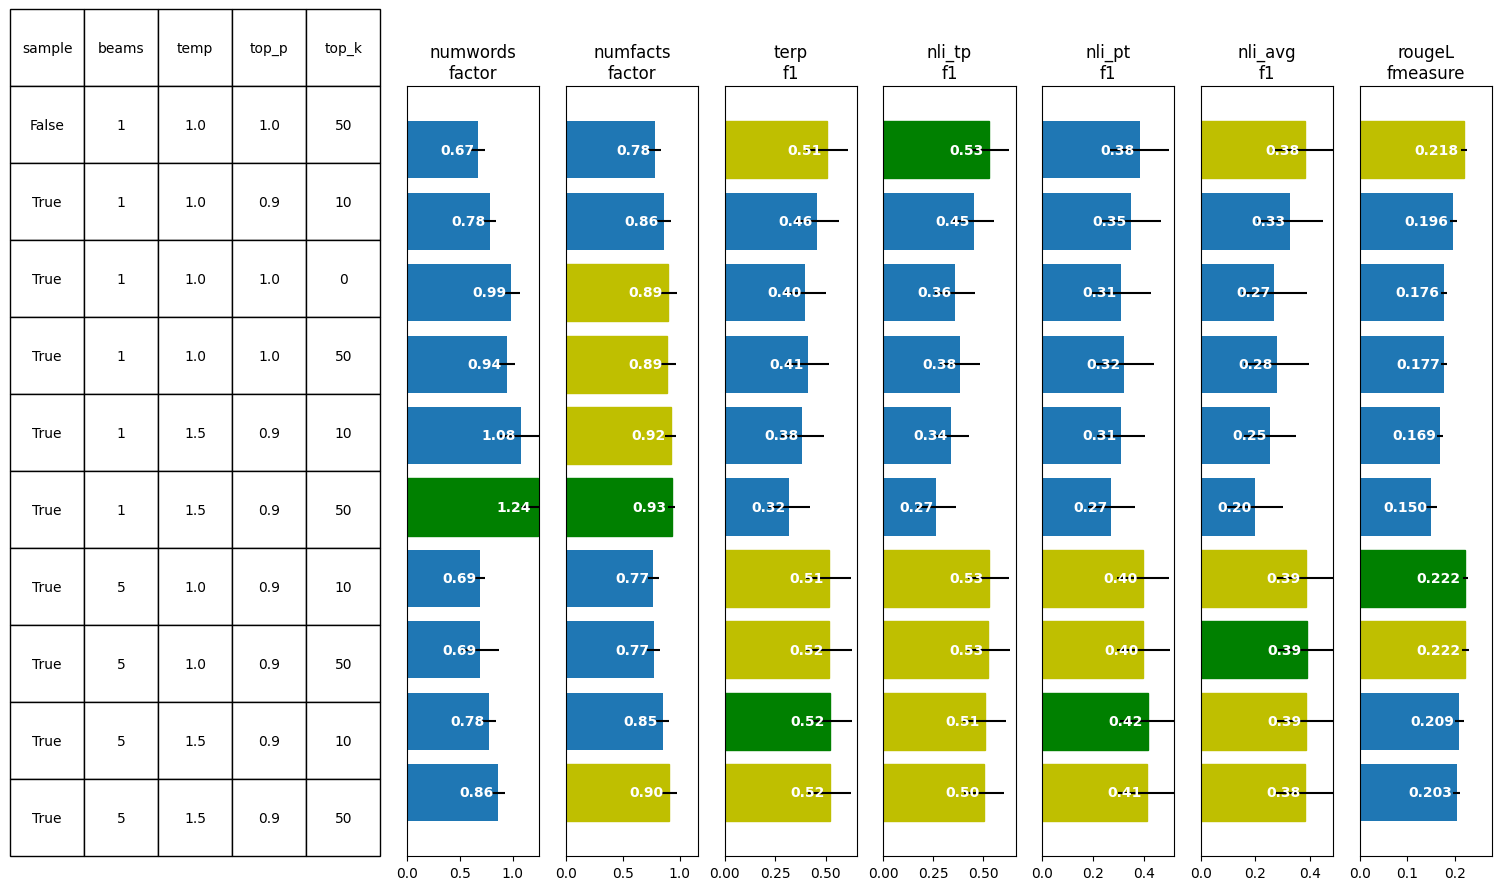

In [125]:
# Define metrics to show
eval_metrics = [('numwords', 'factor'), ('numfacts', 'factor')] + [(m, s) for m in metrics for s in submetrics[m] if (s=='fmeasure' or s=='f1')]
plot_configeval(result_df, eval_metrics)
# plot_configeval_bysession(result_df, eval_metrics)
# plot_sessioneval_byconfig(result_df, eval_metrics)


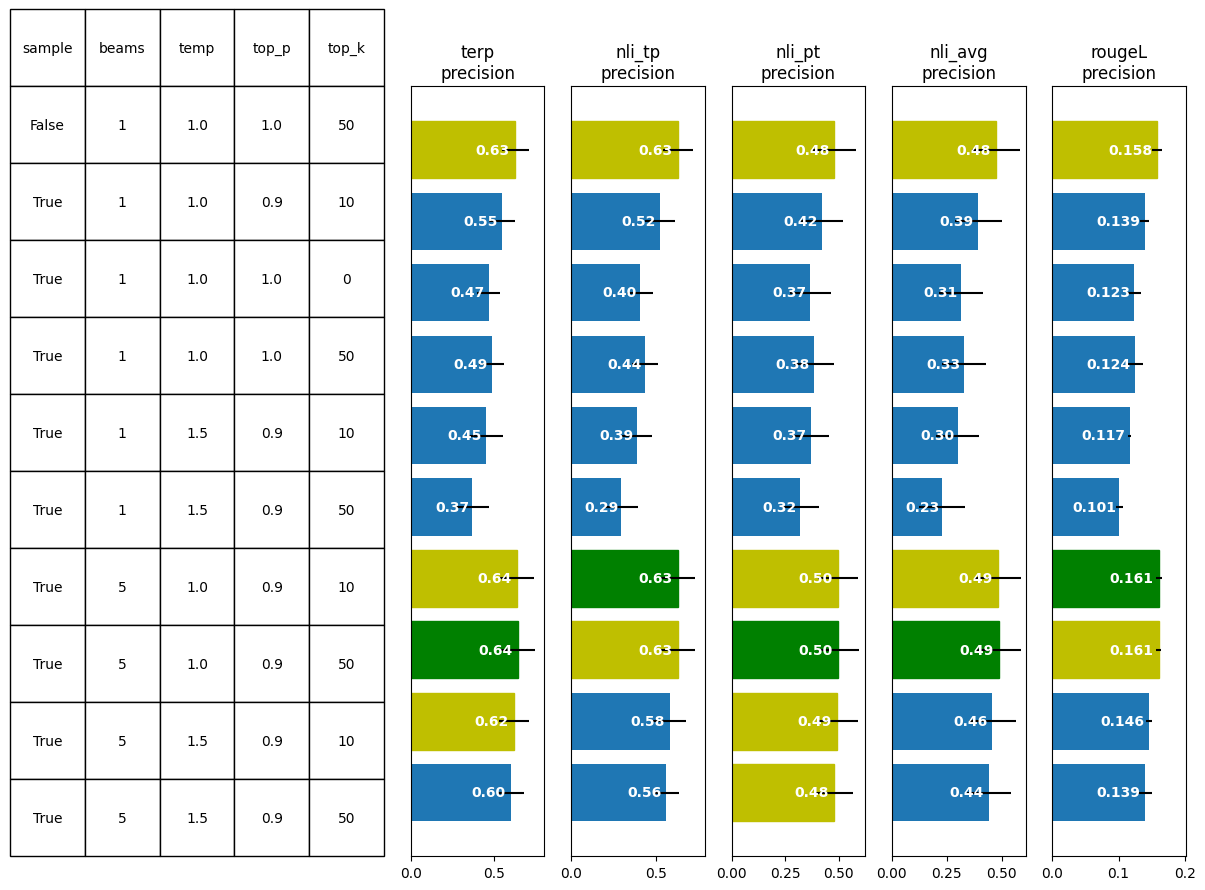

In [126]:
# Define metrics to show
eval_metrics = [(m, s) for m in metrics for s in submetrics[m] if s=='precision']
plot_configeval(result_df, eval_metrics)
# plot_configeval_bysession(result_df, eval_metrics)
# plot_sessioneval_byconfig(result_df, eval_metrics)

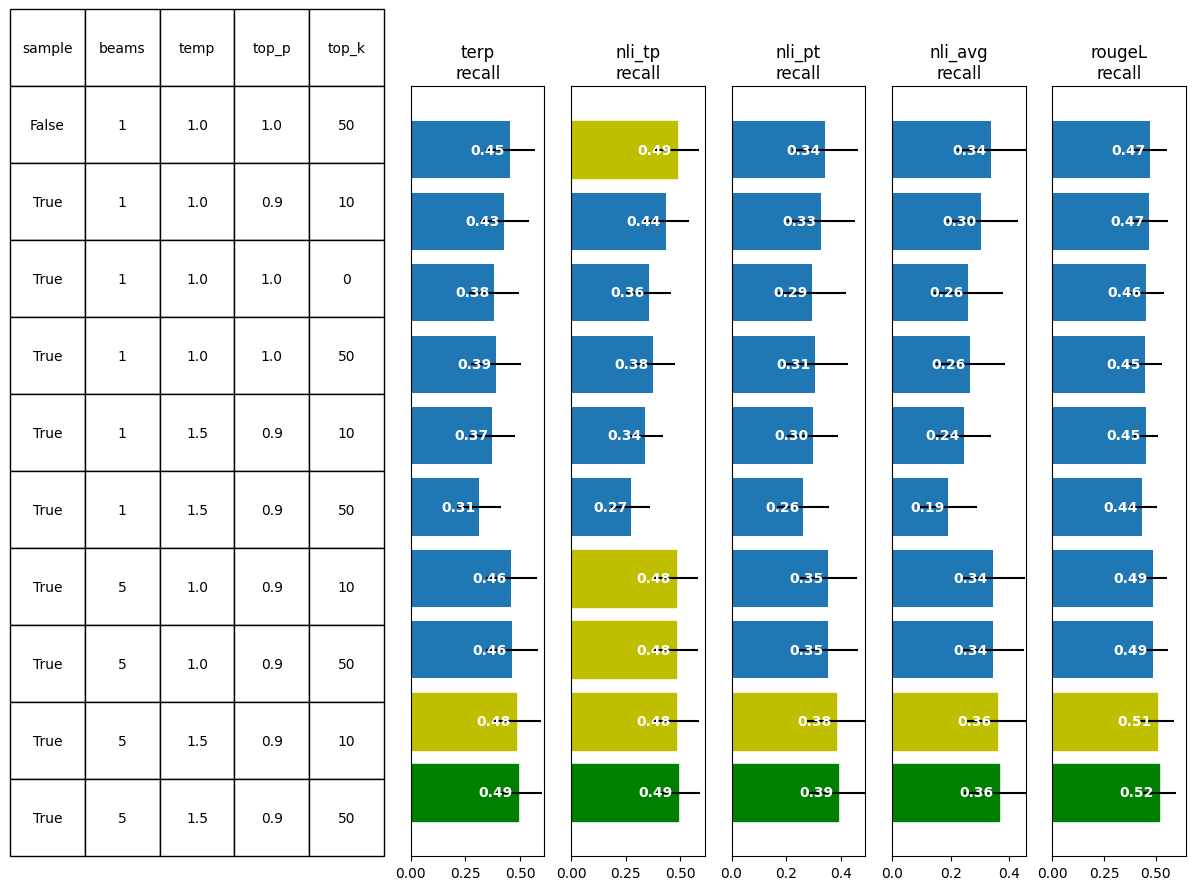

In [92]:
# Define metrics to show
eval_metrics = [(m, s) for m in metrics for s in submetrics[m] if s=='recall']
plot_configeval(result_df, eval_metrics)
# plot_configeval_bysession(result_df, eval_metrics)
# plot_sessioneval_byconfig(result_df, eval_metrics)

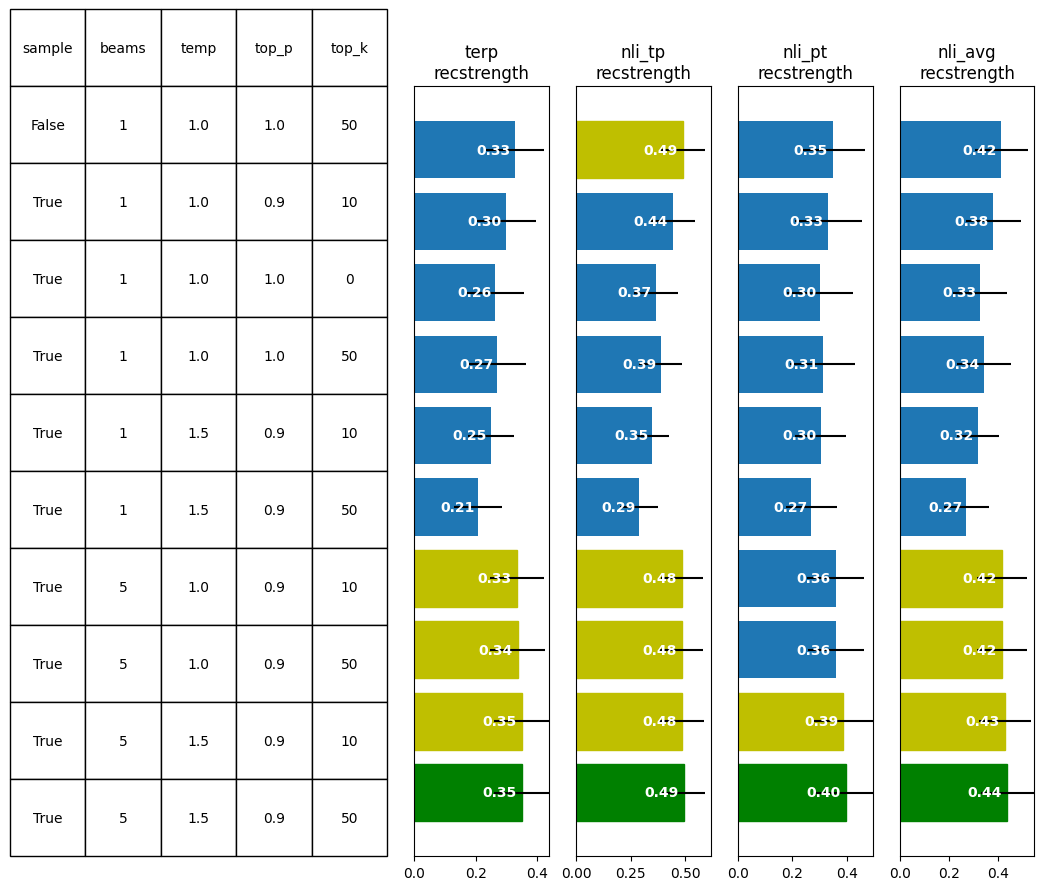

In [93]:
# Define metrics to show
eval_metrics = [(m, s) for m in metrics for s in submetrics[m] if s=='recstrength']
plot_configeval(result_df, eval_metrics)
# plot_configeval_bysession(result_df, eval_metrics)
# plot_sessioneval_byconfig(result_df, eval_metrics)

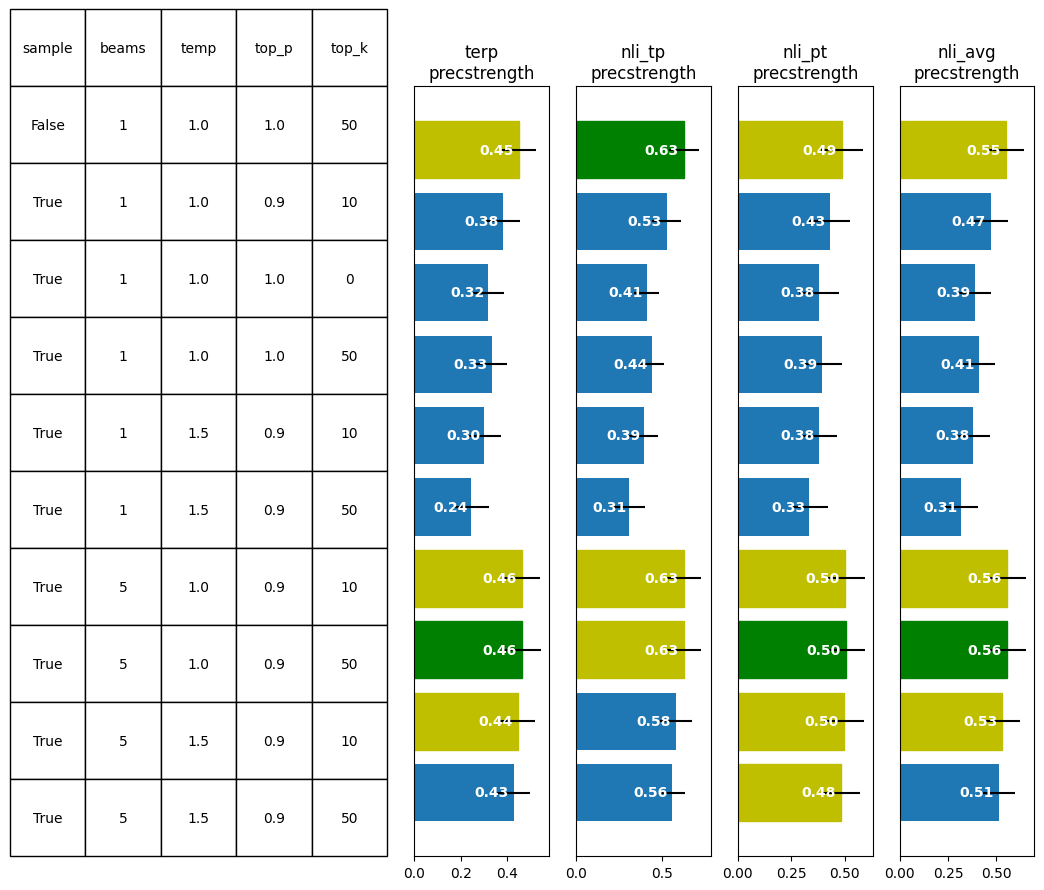

In [94]:
# Define metrics to show
eval_metrics = [(m, s) for m in metrics for s in submetrics[m] if s=='precstrength']
plot_configeval(result_df, eval_metrics)
# plot_configeval_bysession(result_df, eval_metrics)
# plot_sessioneval_byconfig(result_df, eval_metrics)

### Overview of all metrics

In [ ]:
xy = ['rougeL_precision', 'rougeL_recall']
subsets = {
    0: (eval_results_df['do_sample'] == False),
    1: (eval_results_df['do_sample'] == True) & (eval_results_df['num_beams'] == 5) & (eval_results_df['temperature'] == 1.5) & (eval_results_df['top_k'] == 50),
}
colors = ['tab:blue', 'tab:orange']
sub_selection = []
fig, axs = plt.subplots(ncols=len([1, 2, 3, 4]), figsize=(10, 3), sharey=True)

for session, ax in zip(sessions, axs.flatten()):
    for subset in subsets.keys():
        data = eval_results_df[subsets[subset] & (eval_results_df['session'] == session)][xy]
        ax.scatter(data[xy[0]], data[xy[1]], alpha=0.5, s=2, c=colors[subset], label=subset)
        ax.scatter(data[xy[0]].mean(), data[xy[1]].mean(), s=20, c=colors[subset])
    
    ax.set_xlabel(xy[0])
    ax.set_ylabel(xy[1])


In [ ]:
m_list = ['rougeL_precision', 'rougeL_recall', 'nli_pt_f1', 'nli_avg_recall']
subsets = {
    # 0: (eval_results_df['do_sample'] == False),
    0: (eval_results_df['do_sample'] == True) & (eval_results_df['num_beams'] == 5) & (eval_results_df['temperature'] == 1.5) & (eval_results_df['top_k'] == 50),    
    1: (eval_results_df['do_sample'] == True) & (eval_results_df['num_beams'] == 5) & (eval_results_df['temperature'] == 1.5) & (eval_results_df['top_k'] == 10),
}
colors = ['tab:blue', 'tab:orange']
sub_selection = []
fig, ax_grid = plt.subplots(nrows=len(m_list), ncols=len([1, 2, 3, 4]), figsize=(10, 2 * len(m_list)), sharey=True)

for m_id, m in enumerate(m_list):
    axs = ax_grid.flatten()[m_id * 4: (m_id+1) * 4]
    for session, ax in zip(sessions, axs):
        data_df_0 = eval_results_df[subsets[0] & (eval_results_df['session'] == session)].sort_values(by=[m], ascending=False)[m].values
        data_df_1 = eval_results_df[subsets[1] & (eval_results_df['session'] == session)].sort_values(by=[m], ascending=False)[m].values
        dif = sum(data_df_1 - data_df_0)
        data = np.array([
            eval_results_df[subsets[subset] & (eval_results_df['session'] == session)][m].agg(['mean', 'std'])
            for subset in subsets.keys()
        ])
        # print(m, session, len(eval_results_df[subsets[subset] & (eval_results_df['session'] == session)][m]))
        ax.bar(subsets.keys(), height=data[:, 0], yerr=data[:, 1])
        
        ax.set_xticks(range(len(subsets.keys())))
        if session == 1:
            ax.set_ylabel(m)
        ax.set_title(f"dif={dif/len(data_df_0):.2f}")
        if m_id == len(m_list) - 1:
            ax.set_xlabel('Config')


In [ ]:
fig, axs = plt.subplots(nrows=len(submetrics), ncols=len(metrics), figsize=(9,9), sharey=True, sharex=True)

for (m2, m1), ax in zip(itertools.product(submetrics, metrics), axs.flatten()):
    data = [item_stats_df[item_stats_df['session'] == s][(m1, m2)] for s in sessions]
    # print(data)
    plots = ax.violinplot(data, showmeans=True, widths=0.9)
    ax.set_xticks(sessions)
    ax.grid(which='major', axis='y', linestyle='--')

for i in range(len(metrics)):
    axs[0][i].set_title(metrics[i][5:])
    axs[2][i].set_xlabel('session')
for i in range(len(submetrics)):
    axs[i][0].set_ylim(0,1)
    axs[i][0].set_ylabel(submetrics[i])


In [ ]:
fig, axs = plt.subplots(nrows=len(sessions), ncols=len(submetrics), figsize=(9,12), sharey=True, sharex=True)

for (m2, s), ax in zip(itertools.product(submetrics, sessions), axs.flatten()):
    selection = (item_stats_df['session'] == s)
    x = item_stats_df[selection][('eval_terp', m2)]
    y = item_stats_df[selection][('eval_bert', m2)]
    # print(data)
    ax.scatter(x, y, s=10, alpha=0.5)
    ax.grid(which='major', axis='y', linestyle='--')
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_xlabel('terp')
    ax.set_ylabel('bert')

# for i in range(len(submetrics)):
#     axs[0][i].set_title(submetrics[i])
#     axs[0][i].set_xlim(0,1)
#     axs[0][i].set_xticks(np.linspace(0, 1, 6))
# for i in range(sessions):
#     axs[i][0].set_ylim(0,1)
#     # axs[i][0].set_ylabel(i)


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=len(submetrics), figsize=(9,3), sharey=True, sharex=True)

for m2, ax in zip(submetrics, axs.flatten()):
    for s in sessions:
        selection = (item_stats_df['session'] == s)
        x = item_stats_df[selection][('eval_terp', m2)]
        y = item_stats_df[selection][('eval_ter', m2)]
        # print(data)
        ax.scatter(x, y, s=10, alpha=0.3, label=s)
    ax.set_title(m2)
    # ax.legend()
    ax.grid(which='major', axis='y', linestyle='--')
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_xlabel('terp')
    ax.set_ylabel('ter')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xticks(np.linspace(0, 1, 6))

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Review eval_results

In [96]:
# Load the MSC_Summaries dataset

basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_personasummary/"
sessions = [1, 2, 3, 4]
subset = 'test'
MSC_Summaries.set(speaker_prefixes=['<other>', '<self>'])
msc_turns = {session: MSC_Summaries(basedir=basedir, session=session, subset=subset) for session in sessions}

In [97]:
print(eval_results_df.columns)
print(len(eval_results_df))

Index(['convai_id', 'pred_sentences', 'target_sentences', 'num_combinations',
       'terp', 'nli', 'nli_tp', 'nli_pt', 'nli_avg', 'numwords_factor',
       'numfacts_factor', 'rougeL', 'trial_name', 'configfile', 'seed',
       'checkpoint_dir', 'output_dir', 'log_interval', 'loglevel', 'logdir',
       'load', 'save', 'device', 'use_wandb', 'action', 'model', 'task',
       'experiment_name', 'epochs', 'learning_rate', 'valid_interval',
       'patience', 'batch_size', 'skip_eval', 'metrics', 'print_max',
       'temperature', 'top_p', 'top_k', 'do_sample', 'num_beams', 'num_turns',
       'lm_loss_factor', 'nofact_weight', 'clf_loss', 'decoder_max',
       'bart_base', 'datadir', 'basedir', 'train_samples', 'valid_samples',
       'test_samples', 'java_home', 'terpdir', 'tmpdir', 'nli_model',
       'speaker_prefixes', 'nofact_token', 'add_tokens', 'len_context',
       'session', 'new_agent', 'load_other', 'include_persona_other',
       'include_history_other', 'input_order_other'

In [98]:
eval_results_df[['session', 'numwords_factor']].groupby(['session']).count()

,numwords_factor
session,
1,5010
2,5010
3,5010
4,5010


In [99]:
# Add item results as columns in DataFrame
for metric in metrics:
    if metric not in ['numwords', 'numfacts']:
        for submetric in submetrics[metric]:
            if submetric not in ['scores']:
                print(eval_results_df.iloc[0][metric].keys())
                if metric == 'rougeL':
                    eval_results_df[f"{metric}_{submetric}"] = eval_results_df[metric].apply(lambda row: row[f"{metric}_{submetric}"])
                else:
                    eval_results_df[f"{metric}_{submetric}"] = eval_results_df[metric].apply(lambda row: row[submetric.replace('recstrength', 'rec_strength')])

dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_strength'])
dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_strength'])
dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_strength'])
dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_strength'])
dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_strength'])
dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_strength'])
dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_strength'])
dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_strength'])
dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_strength'])
dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_strength'])
dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_strength'])
dict_keys(['scores', 'f1', 'precision', 'recall', 'prec_strength', 'rec_stre

In [100]:
selection = (eval_results_df['do_sample'] == True) & (eval_results_df['session'] == 3)
cols = ['pred_sentences', 'target_sentences']
metric = 'nli_pt'
submetric = 'precision'
metric_key = f"{metric}_{submetric}"

sample = eval_results_df[selection][cols + [metric_key]].sort_values(by=metric_key, ascending=True).head(25).values
for s in sample:
    print(s[2], s[0], s[1])

0.0 ['i have never bow hunting', 'i want to learn to hunt'] ['i live in oregon', "i've like hunting", 'i love medium rare steak', "i've stuffed a deer head before", 'i have experience with a shotgun']
0.0 ['i do not take care of pets', 'i have a 7 day a week job', 'i have pets', 'i have a few hours of work in the evening'] ['i own several farm animals', 'i have very limited time during the day for myself']
0.0 ['my dog wylie is ill', 'i have a son', 'my son is a bit lethargic and dragging himself around', 'i have a neighbor who has two pugs'] ["i have an appointment at the vet's office today for my dog, wylie", 'i take my dog to the ice cream stand and get him a treat', 'i like to go to the ice cream stand', 'i like pugs', 'i like rescued pets', 'i have adopted a dog']
0.0 ['i like safaris, animals, and exotic animal traveling'] ["i am interested in trying authentic jollof rice while i'm in africa", "i am looking forwarded to going on safari's while i'm in africa"]
0.0 ['i am a fan of 

In [101]:
def get_elem(x):
    return x[0]

selection = (eval_results_df['target_sentences'].apply(get_elem) == ' ')
cols = ['session', 'convai_id', 'pred_sentences', 'target_sentences']

eval_results_df[selection][cols]


,session,convai_id,pred_sentences,target_sentences
15,4,test_27,[ ],[ ]
457,4,test_914,[i like beaches],[ ]
41,3,test_70,[ ],[ ]
202,3,test_409,[i would prefer not to have a giraffe tooth],[ ]
260,3,test_536,[i have had a gym membership],[ ]
...,...,...,...,...
399,3,test_819,[i don't think your fiance is a conundrum],[ ]
403,3,test_823,[ ],[ ]
115,2,test_201,"[i am interested in microploxing, my husband d...",[ ]
296,2,test_626,[my cats are in captivity],[ ]


In [102]:
selection = eval_results_df['session'] == 3
print(eval_results_df.iloc[0].values)

['test_0'
 list(['i am looking for a new gym', 'i am looking forward to getting into shape', 'i prefer to workout alone', 'i like programming', 'i work', 'i work 8-5'])
 list(['i am joining a gym near me', 'i run', 'i am looking forward to getting in shape', 'i prefer to work out alone', 'i work as a programmer', 'i am tired of sitting in front of a computer all day', 'i work from 8 to 5'])
 42
 {'scores': [[0.7040180563926697, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.9077003002166748, 0.0, 0.38827913999557495], [0.9566409587860107, 0.1945684850215912, 1.0, 0.946806788444519, 1.0, 1.0], [1.0, 0.9076386094093323, 0.4972473680973053, 1.0, 0.9512909650802612, 1.0], [1.0, 1.0, 1.0, 1.0, 0.856161892414093, 0.9339286684989929], [0.9836938381195068, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.9582338333129883, 1.0, 1.0, 0.9512909650802612, 0.4972473680973053]], 'f1': 0.7692307706415297, 'precision': 0.8333333134651184, 'recall': 0.7142857313156128, 'prec_strength': 0.5513644814491272, 'rec_strength'

### Heatmaps

Number of dialog_id's:  5


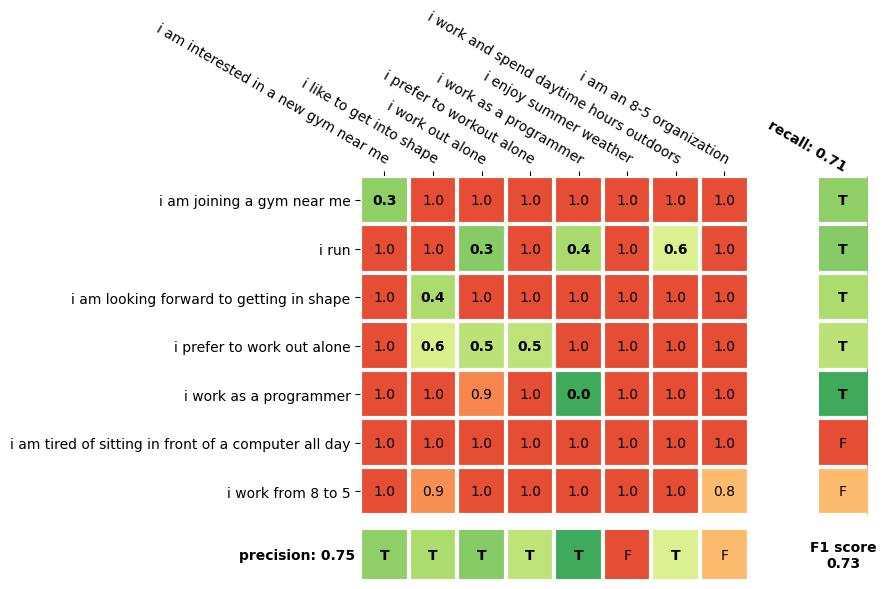

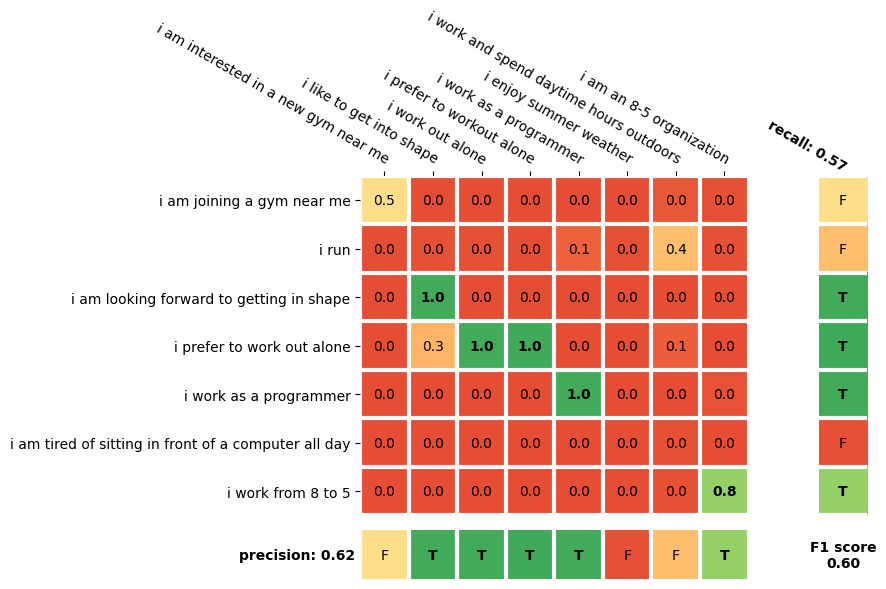

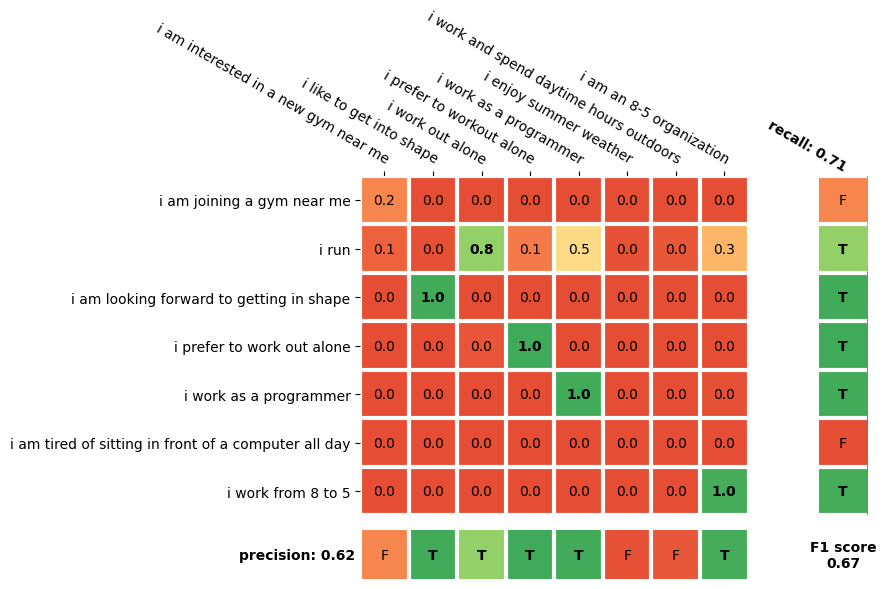

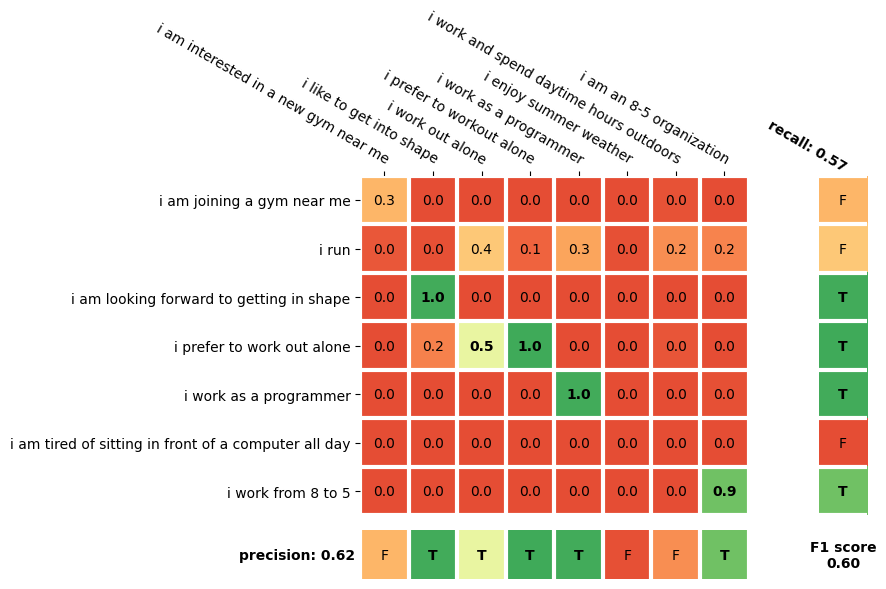

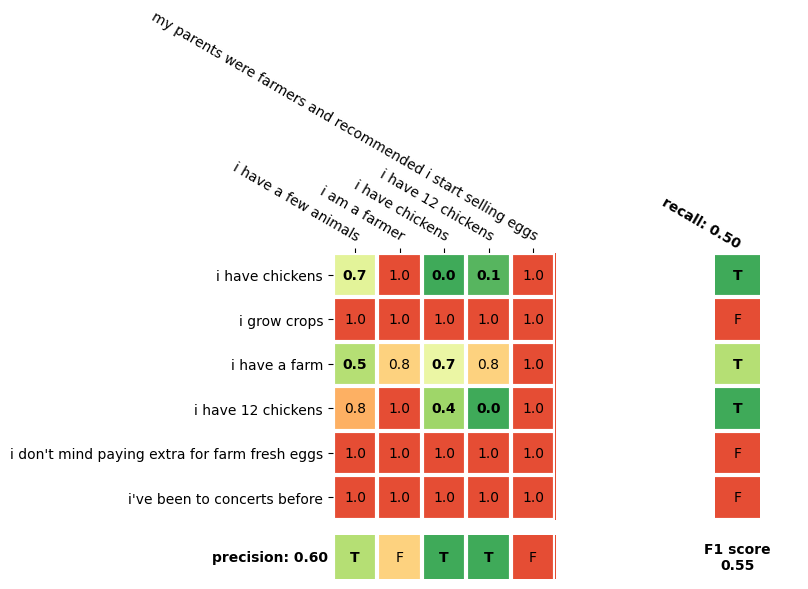

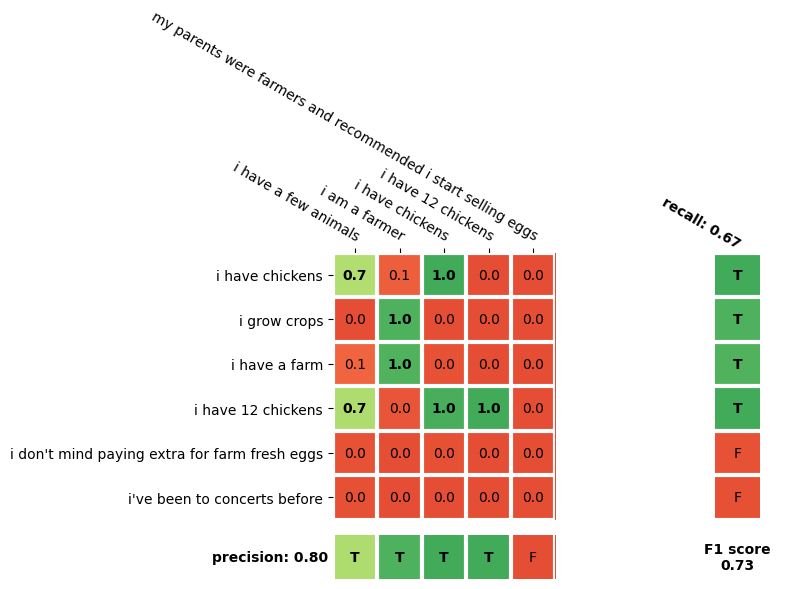

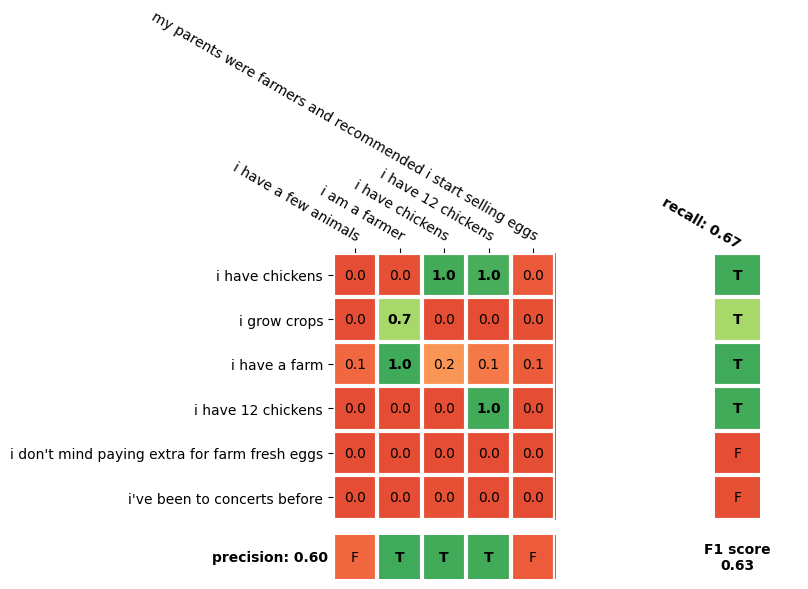

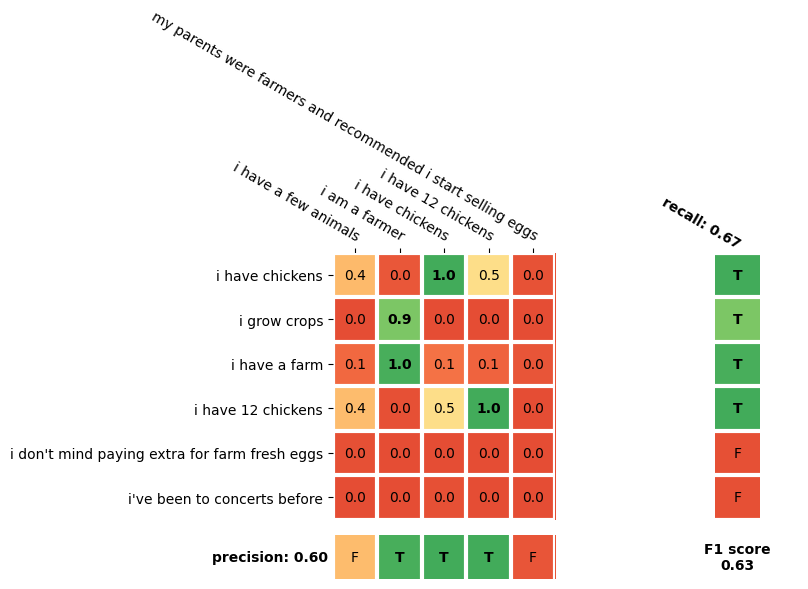

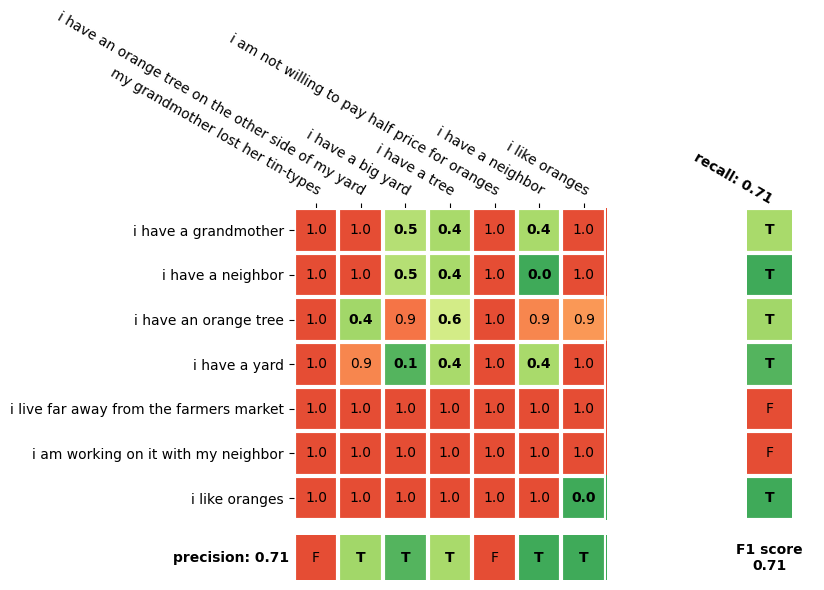

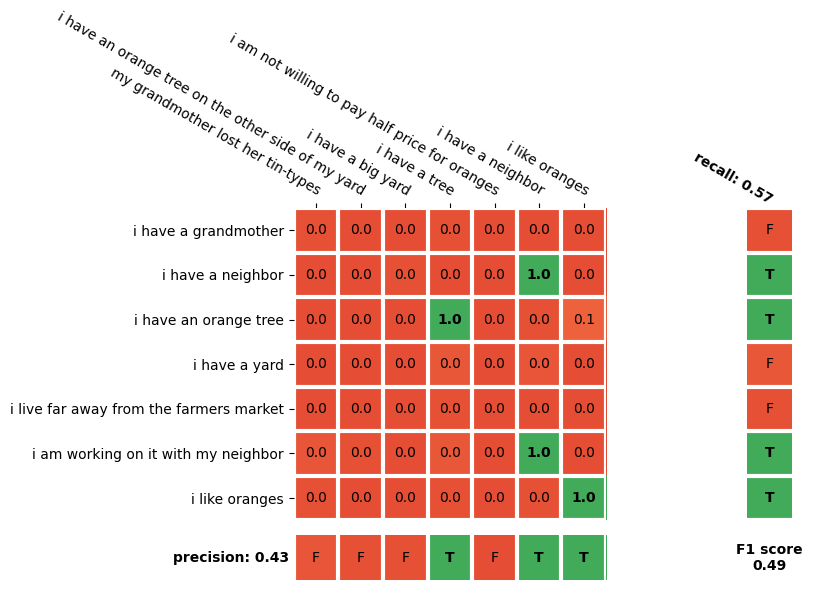

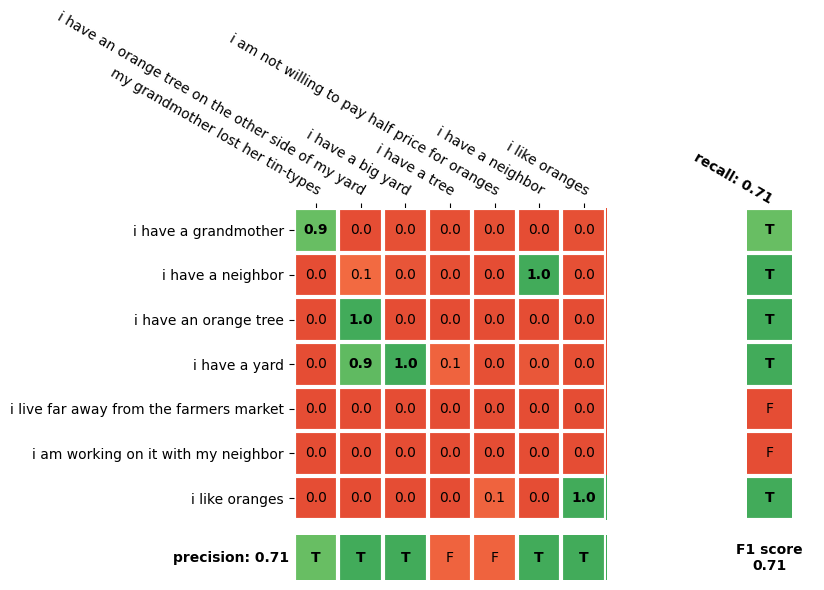

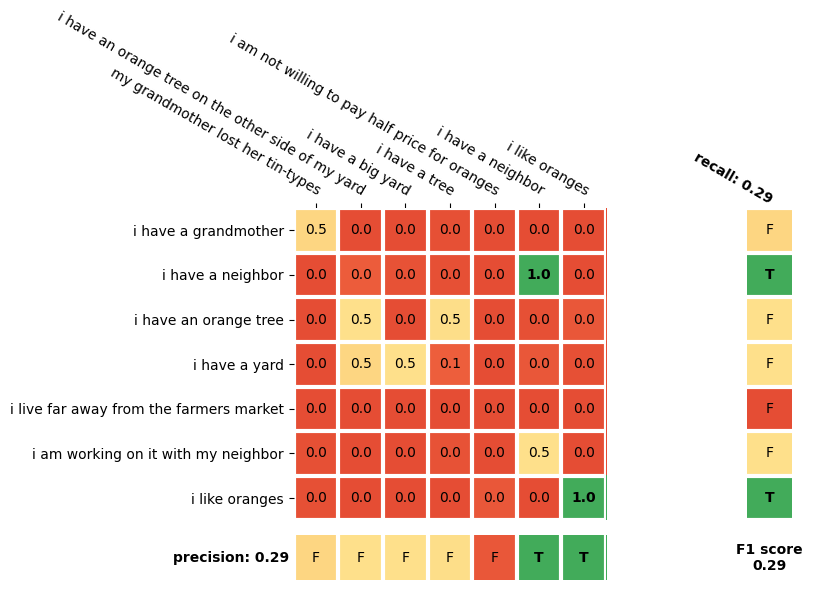

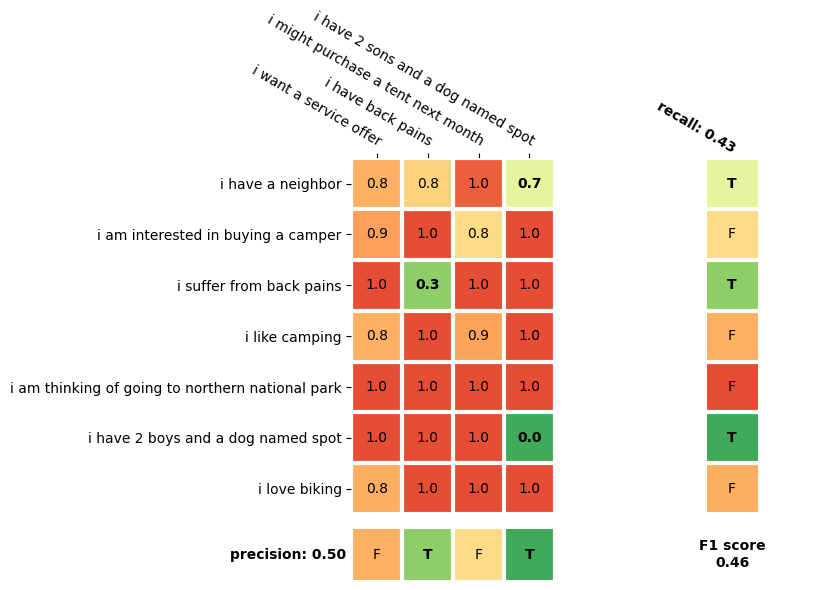

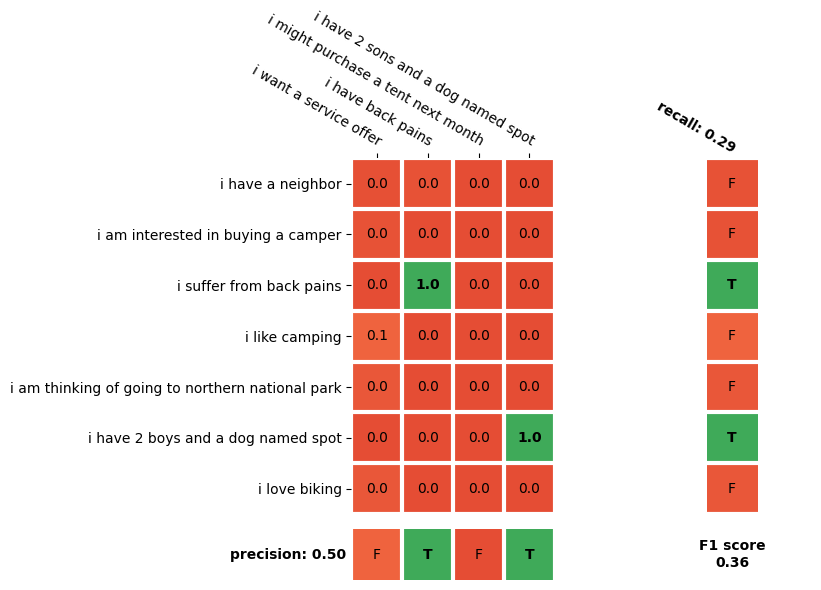

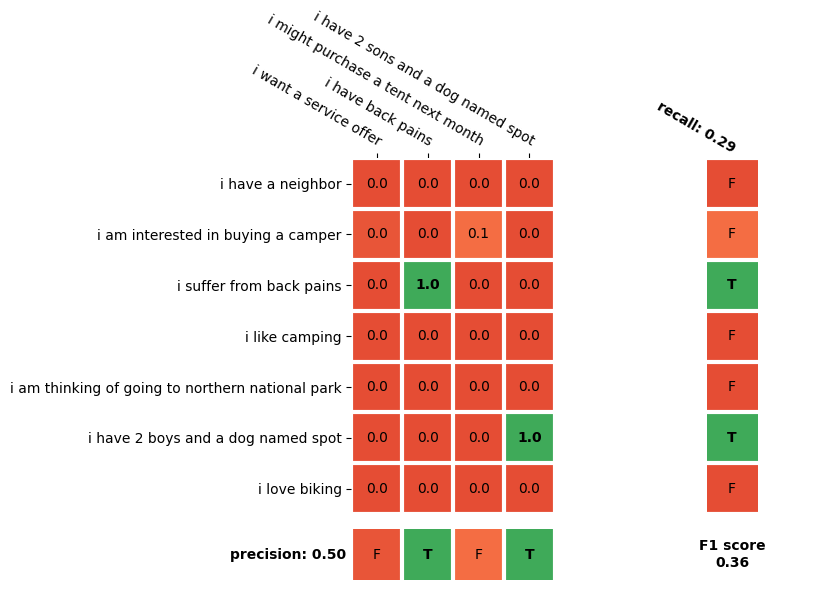

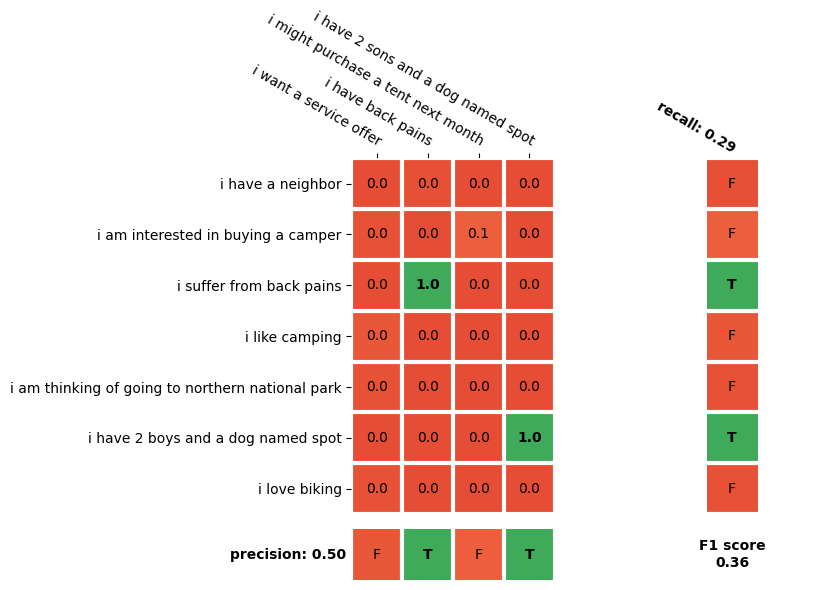

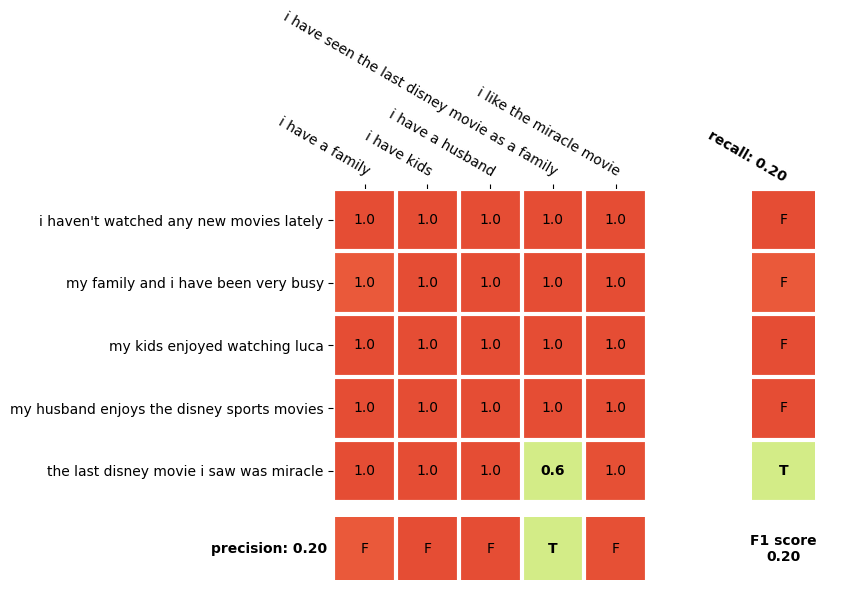

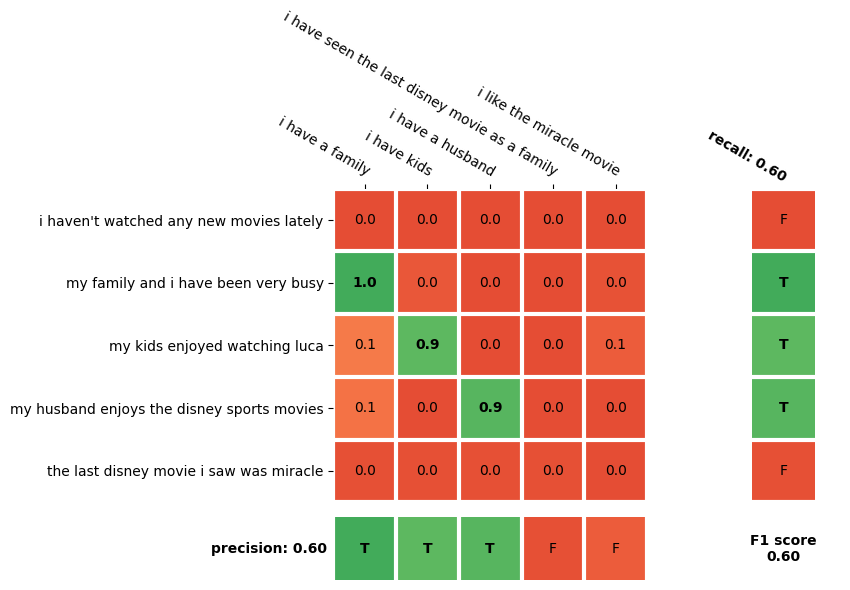

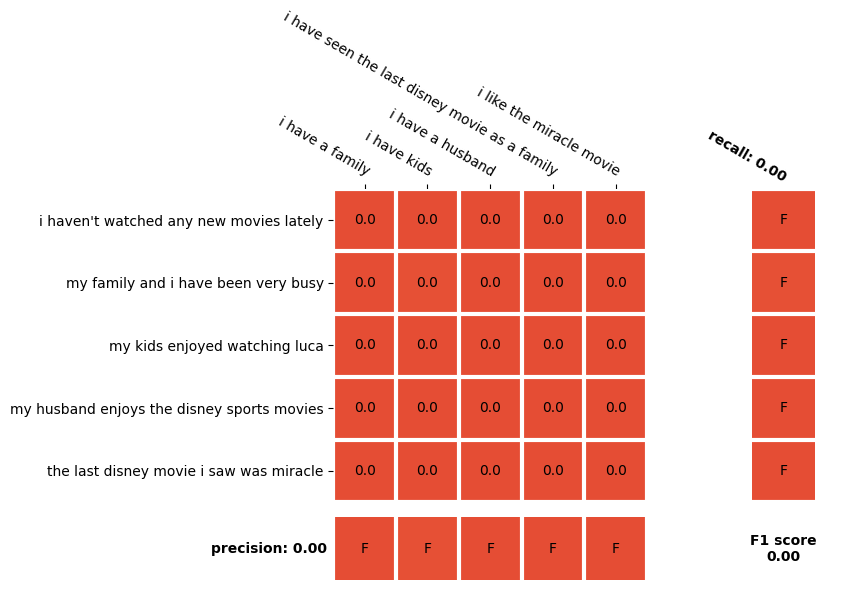

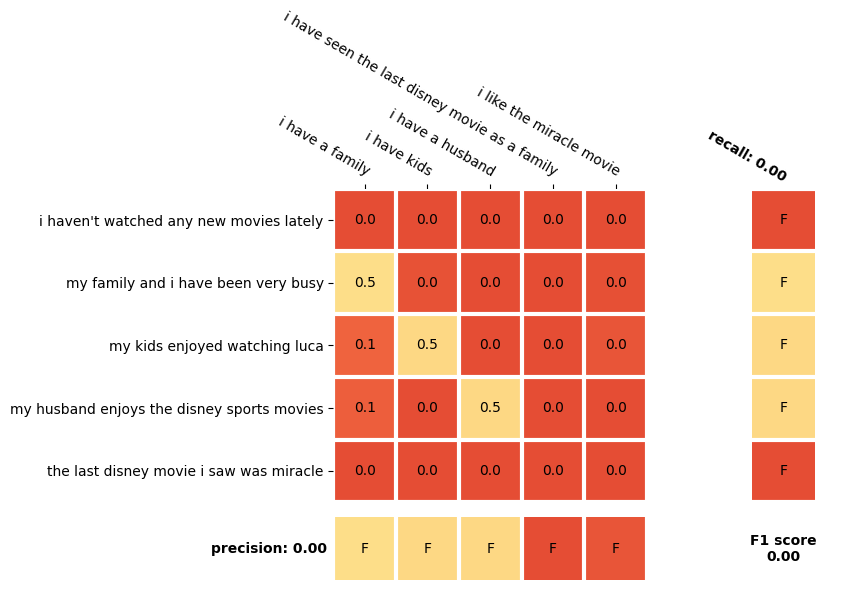

In [67]:
savedir = "../output/"
session = 4
subset = 'test'
results_dict = list(evalresults_dict.values())[0]
results_dict = {k:results_dict[k] for k in list(results_dict.keys())[:5]}  # select subset of first X dialogues
print("Number of dialog_id's: ", len(results_dict.keys()))
plot_heatmaps(results_dict, session, subset, savedir)


In [51]:
results_dict[4]

{'convai_id': 'test_8',
 'pred_sentences': ['i have kids',
  'i am a stay at home mom',
  'i love romance movies',
  'i have 2 jobs'],
 'target_sentences': ['i have kids',
  'i have kids in school',
  'i am busy',
  'i am a stay at home mom',
  'i love romance movies',
  'i have a partner'],
 'num_combinations': 24,
 'terp': {'scores': [[0.0, 1.0, 1.0, 0.6051335334777832],
   [0.5707746148109436, 1.0, 1.0, 0.9080064296722412],
   [1.0, 0.8639863133430481, 1.0, 1.0],
   [1.0, 0.0, 1.0, 1.0],
   [1.0, 1.0, 0.0, 1.0],
   [0.7458710670471191, 0.9724134802818298, 1.0, 0.7782739400863647]],
  'f1': 0.9090908972685001,
  'precision': 1.0,
  'recall': 0.8333333134651184,
  'prec_strength': 0.8487166166305542,
  'rec_strength': 0.6365613341331482},
 'nli': {},
 'nli_tp': {'scores': [[0.9945722222328186,
    0.01209141593426466,
    0.0014008453581482172,
    0.01069134846329689],
   [0.939182698726654,
    0.0003966977819800377,
    0.0011779807973653078,
    0.009220308624207973],
   [0.006986

In [21]:
len(results_dict.keys())

5

In [ ]:
def get_value(metric_dict, key):
    v = metric_dict[key]
    return v
scores_df = pd.concat([
    pd.concat([
        eval_results_df[m].apply(lambda x: get_value(x, key))
        for key in submetrics
    ], axis=1)
    for m in ['ter', 'bert', 'terp']
], axis=1)
scores_df.columns = pd.MultiIndex.from_tuples([(m1, m2) for m1, m2 in itertools.product(['ter', 'bert', 'terp'], submetrics)])
eval_results_df = pd.concat([
    eval_results_df,
    scores_df
], axis=1)
eval_results_df.head()

### Length

In [ ]:
def get_length(sentence_list):
    l = sum([len(s.split()) for s in sentence_list])
    return l

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for s in [1, 2, 3, 4]:
    selection = (eval_results_df['session'] == s)
    x = eval_results_df[selection]['target_sentences'].apply(lambda x: get_length(x))
    y = eval_results_df[selection]['pred_sentences'].apply(lambda x: get_length(x))
    ax.scatter(x, y, s=10, alpha=0.3, label=s)
ax.set_title("Relation between target length and prediction length")
ax.legend()
# ax.grid(which='major', axis='y', linestyle='--')
# ax.grid(which='major', axis='x', linestyle='--')
ax.set_xlabel('words in target')
ax.set_ylabel('words in prediction')
ax.set_xlim(0, 100)
print(ax.get_xlim())
ax.set_ylim(ax.get_xlim())


In [ ]:
def get_length(sentence_list):
    l = sum([len(s.split()) for s in sentence_list])
    return l

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
bin_edges = np.linspace(0,80, 41)

x = eval_results_df['target_sentences'].apply(lambda x: get_length(x))
y = eval_results_df['pred_sentences'].apply(lambda x: get_length(x))
ax_hist = ax.hist2d(x, y, bins=(bin_edges, bin_edges), cmap='Greys')
fig.colorbar(ax_hist[3])
ax.set_xticks(np.linspace(0,100,11))
ax.set_xlim(0, 80)
ax.set_ylim(ax.get_xlim())
ax.set_title("Relation between target length and prediction length")
# ax.grid(which='major', axis='y', linestyle='--')
# ax.grid(which='major', axis='x', linestyle='--')
ax.set_xlabel('words in target')
ax.set_ylabel('words in prediction')
ax.set_xlim(0, 80)
ax.set_ylim(ax.get_xlim())


In [ ]:
def get_length(sentence_list):
    l = sum([len(s.split()) for s in sentence_list])
    return l

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,3), sharey=True)
bin_edges = np.linspace(0,80, 41)
for s, ax in zip([1, 2, 3, 4], axs):
    selection = (eval_results_df['session'] == s)
    x = eval_results_df[selection]['target_sentences'].apply(lambda x: get_length(x))
    y = eval_results_df[selection]['pred_sentences'].apply(lambda x: get_length(x))
    h = ax.hist2d(x, y, bins=(bin_edges, bin_edges))
    ax.set_xticks(np.linspace(0,100,11))
    ax.set_xlim(0, 80)
    ax.set_ylim(ax.get_xlim())
# ax.set_title("Relation between target length and prediction length")
# ax.legend()
# # ax.grid(which='major', axis='y', linestyle='--')
# # ax.grid(which='major', axis='x', linestyle='--')
# ax.set_xlabel('words in target')
# ax.set_ylabel('words in prediction')

fig.colorbar(h[3], ax=ax)

In [ ]:
def get_length(sentence_list):
    l = len(sentence_list)
    return l

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for s in [1, 2, 3, 4]:
    selection = (eval_results_df['session'] == s)
    x = eval_results_df[selection]['target_sentences'].apply(lambda x: get_length(x))
    y = eval_results_df[selection]['pred_sentences'].apply(lambda x: get_length(x))
    ax.scatter(x, y, s=10, alpha=0.3, label=s)
ax.set_title("Relation between target length and prediction length")
ax.legend()
# ax.grid(which='major', axis='y', linestyle='--')
# ax.grid(which='major', axis='x', linestyle='--')
ax.set_xlabel('sentences in target')
ax.set_ylabel('sentences in prediction')
ax.set_xlim(0)
print(ax.get_xlim())
ax.set_ylim(ax.get_xlim())


In [ ]:
best_summaries = eval_results_df.sort_values(by=('terp', 'f1'), ascending=False).head(10)
m1m2 = [(m1, m2) for m1, m2 in itertools.product(['ter', 'bert', 'terp'], submetrics)]

for i in range(len(best_summaries)):
    print("Target:")
    print('\n'.join(best_summaries.iloc[i]['target_sentences']))
    print("Prediction")
    print('\n'.join(best_summaries.iloc[i]['pred_sentences']))
    print(best_summaries.iloc[i][m1m2])

## Take sample from dataset for analysis

In [ ]:
max_inputwords = df['inputwords'].max()
bin_boundaries = [0, 10, 20, 30, 40, 50, 60, 80, 100, max_inputwords]
bins = [(lower + 1, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

samples = []
for s in selection.keys():
    for lower, upper in bins:
        subset = (selection[s] & (df['inputwords'] >= lower) & (df['inputwords'] <= upper))
        samples.append(df[subset].sample(n=min(10, len(df[subset])), axis=0, replace=False, ignore_index=False).index)

sampled = pd.MultiIndex.from_tuples([id for indexlist in samples for id in indexlist])
sampled

In [ ]:
output_dir = "/Users/FrankVerhoef/Programming/PEX/output/"
filename = "sample_newnli.csv"

df.loc[sampled].to_csv(output_dir + filename, sep='\t') 

In [ ]:
# Load the saved csv file (with additional columns)
df_index = pd.read_csv(output_dir + "sample_index.csv", sep=';')

# Extract the index
sampled_index = pd.MultiIndex.from_arrays(df_index[['i0', 'i1', 'i2']].values.T)

In [ ]:
# Save specified columns
df.loc[sampled_index][['nli_pred', 'nli_target']].to_csv(output_dir + 'new_nli.csv', sep='\t') 

In [ ]:
df.loc[(4,258,4)]['history']